# (23) vH16 — tst, lin

**Motivation**: host = ```any```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: mach

## vH16

$T = 64$

### Low beta

$(T, \beta) = (64, 24.0)$

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jacob|lin')

seq_len = 64
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 3/8 * seq_len
cfg_tr['batch_size'] = 300
cfg_tr['epochs'] = 1000

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.n_iters

poisson_vH16_t-64_z-[512]_<jacob|lin>
b300-ep1000-lr(0.002)_beta(24:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_09_25,20:52)

343000

In [ ]:
tr.train()

epoch # 485, avg loss: 39.049843:  48%|▍| 485/1000 [24:32:44<26:39:04, 186.30s/i

### Medium beta

$(T, \beta) = (64, 32.0)$

In [3]:
model_name = 'poisson_vH16_t-64_z-[512]_<jacob|lin>'
fit_name = 'u:(8.0)-du:(7.0)_b200-ep300-lr(0.002)_beta(32:0x0.1)_temp(0.05:lin-0.5)_gr(500)_(2024_09_12,20:23)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [4]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (64, 32.0))

In [5]:
tr.model.cfg.clamp_u, tr.model.cfg.clamp_du

(8.0, 7.0)

In [7]:
print(tr.model.layer.n_exp)

tensor([ 25,  34,  45,  60,  78,  96, 114, 129, 140, 147, 152, 154, 156, 156,
        156, 156, 156, 156, 155, 155, 155, 155, 154, 154, 154, 153, 153, 153,
        153, 153, 153, 153, 153, 153, 152, 152, 152, 152, 152, 152, 152, 152,
        152, 152, 152, 152, 152, 151, 151, 151, 152, 151, 151, 152, 151, 151,
        151, 151, 151, 151, 151, 151, 151, 151], device='cuda:2',
       dtype=torch.int32)

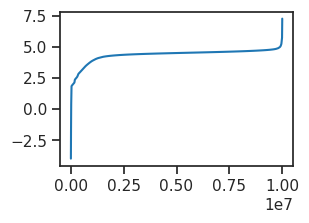

In [8]:
plt.plot(sorted(tr.model.stats['u_max']))

In [12]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

u_max.max(), du_max.max()

(7.269288539886475, 2.424907684326172)

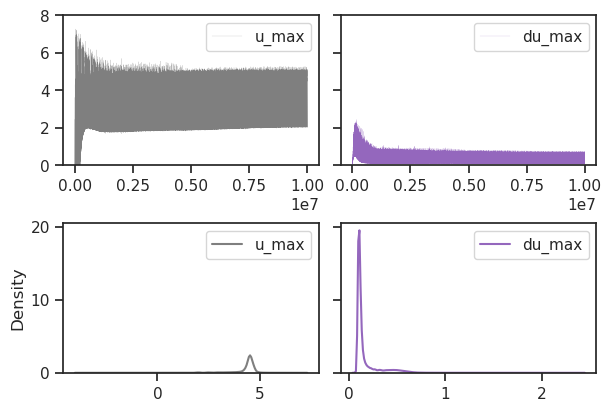

In [13]:
fig, axes = create_figure(2, 2, sharey='row')

axes[0, 0].plot(u_max, color='C7', lw=0.1, label='u_max')
axes[0, 1].plot(du_max, color='C4', lw=0.1, label='du_max')
axes[0, 1].set(ylim=(0, 8))

sns.kdeplot(u_max, color='C7', label='u_max', ax=axes[1, 0])
sns.kdeplot(du_max, color='C4', label='du_max', ax=axes[1, 1])

add_legend(axes)
plt.show()

In [14]:
grad = np.array(list(tr.stats['grad'].values()))
(grad > tr.cfg.grad_clip).sum(), np.round((grad > tr.cfg.grad_clip).mean(), 3)

(0, 0.0)

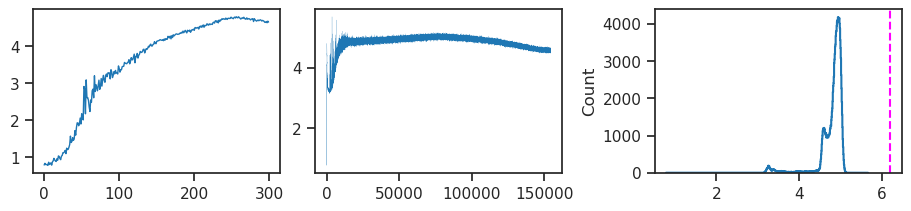

In [15]:
fig, axes = create_figure(1, 3)

axes[0].plot(np.log(grad)[:300], lw=1)
axes[1].plot(np.log(grad), lw=0.1)

axes[2].axvline(np.log(tr.cfg.grad_clip), color='magenta', ls='--')
histplot(np.log(grad), ax=axes[2])

plt.show()

In [8]:
tr.model.layer._cfg.clamp_u = 5
tr.model.layer._cfg.clamp_du = None

100%|███████████████████████████████████| 2/2 [00:55<00:00, 27.56s/it]


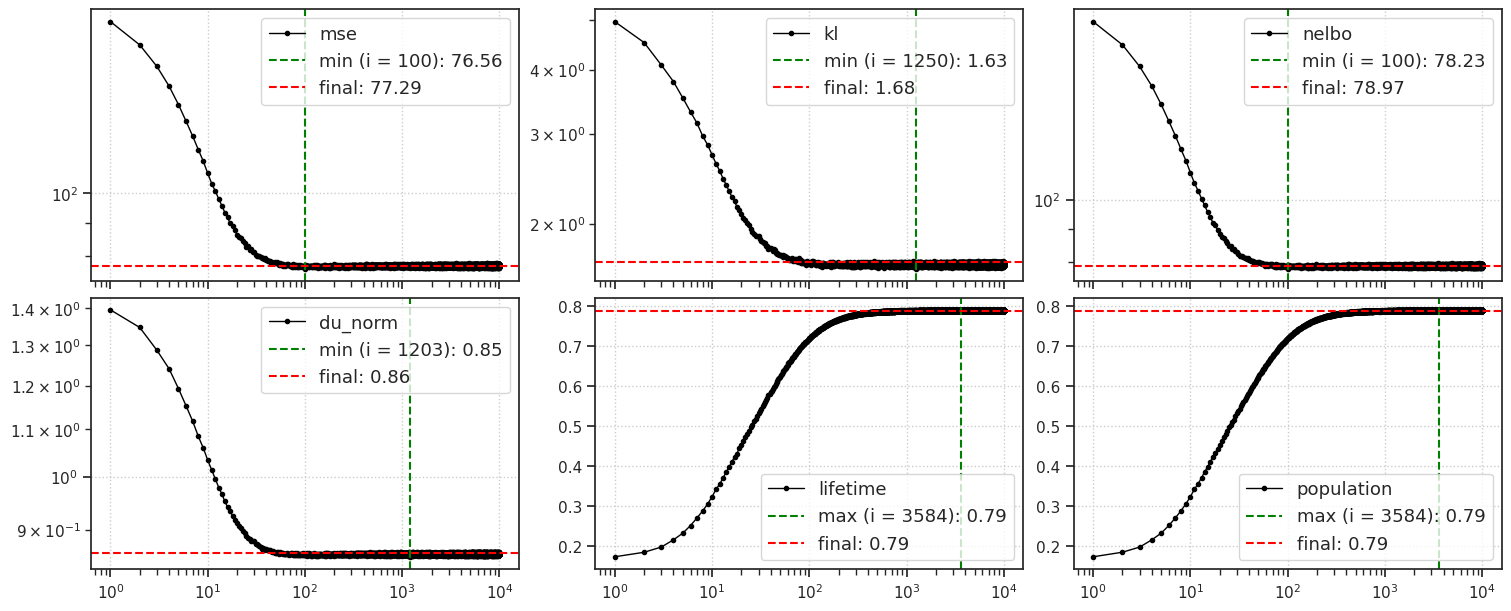

In [9]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=2,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

In [10]:
tr.model.layer._cfg.clamp_u, tr.model.layer._cfg.clamp_du

(5, None)

100%|███████████████████████████████████| 2/2 [01:05<00:00, 32.65s/it]


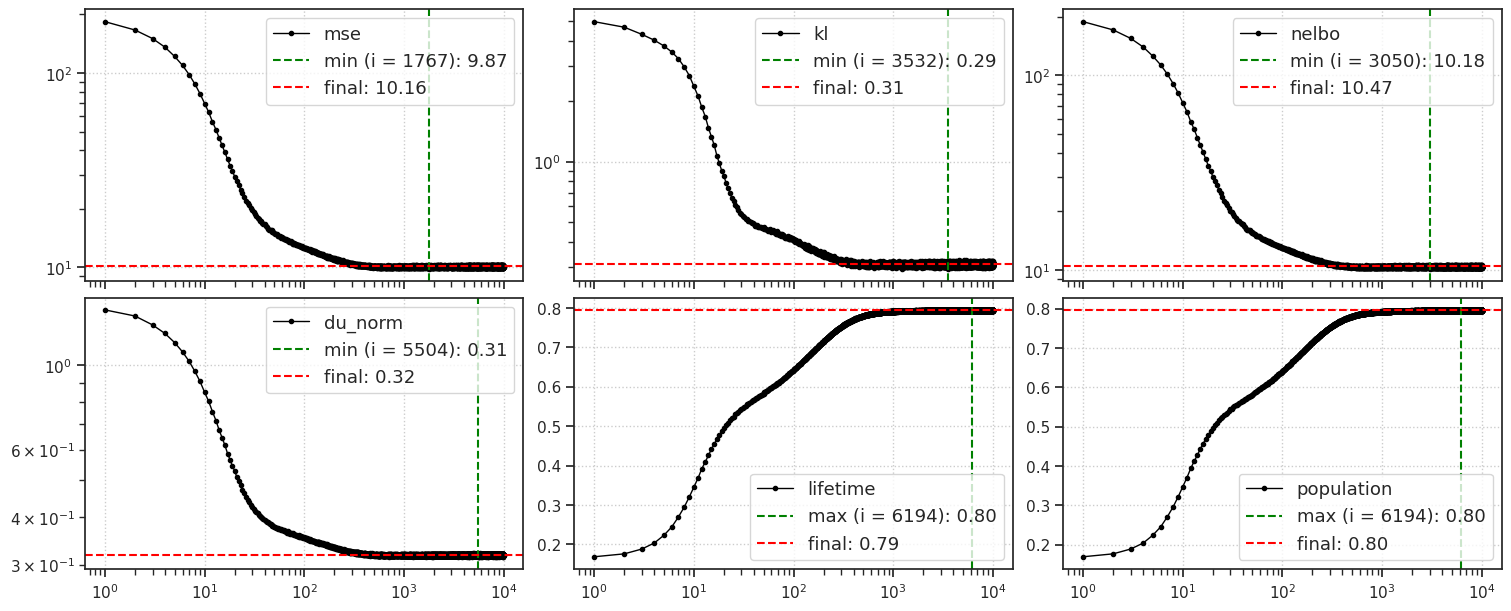

100%|███████████████████████████████████| 2/2 [01:00<00:00, 30.26s/it]


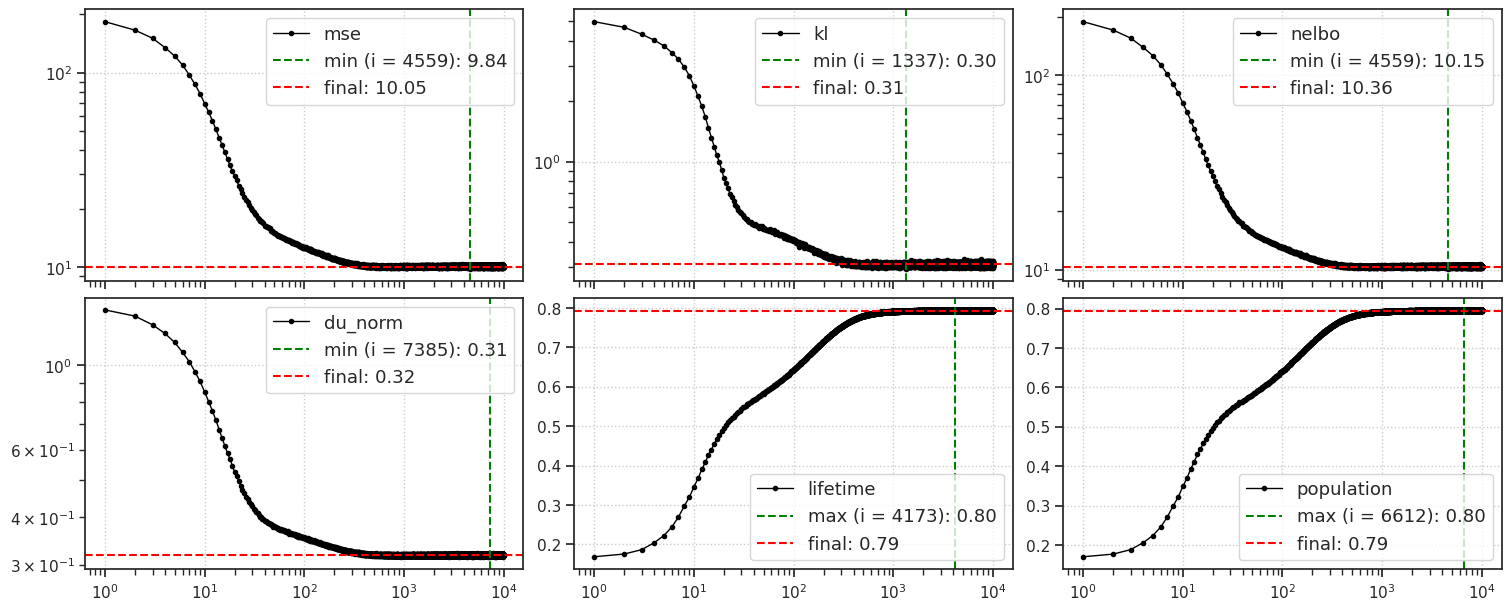

In [10]:
## Was: (clamp_u, clamp_du) = (8.0, 7.0)

100%|█████████████████████████████████| 20/20 [09:39<00:00, 28.96s/it]


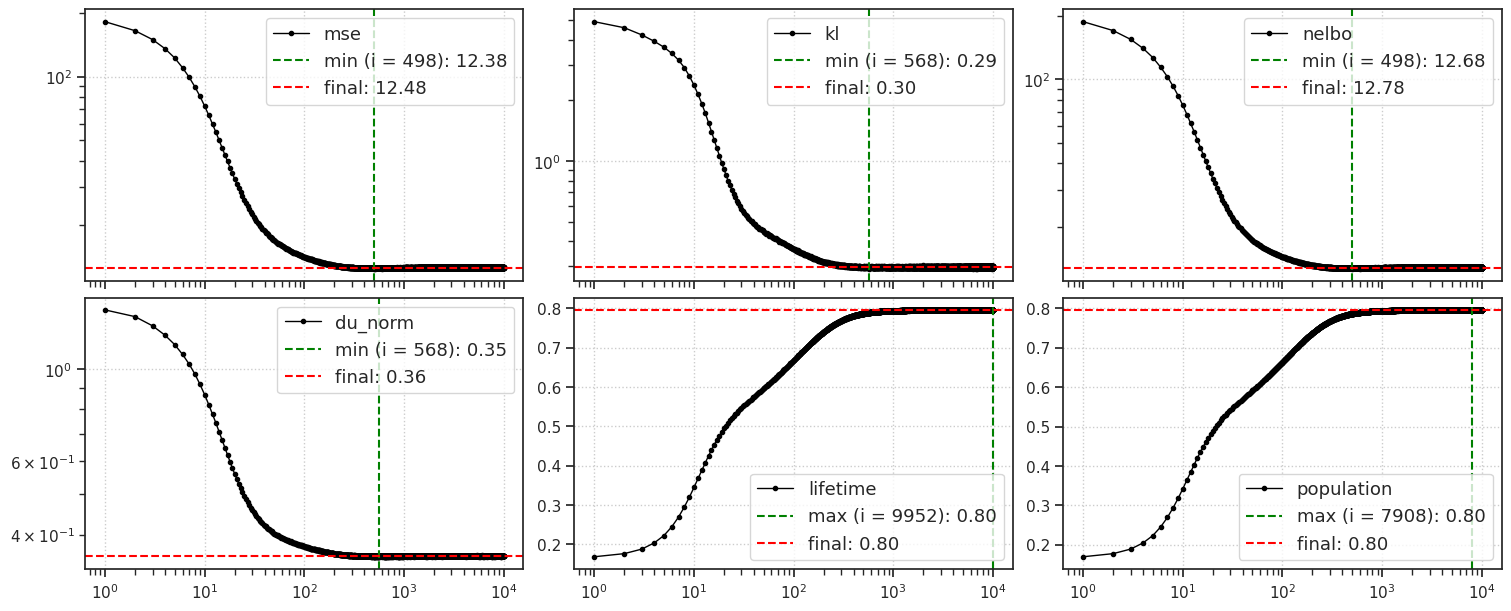

In [16]:
## Was: clamp_du = 7.0

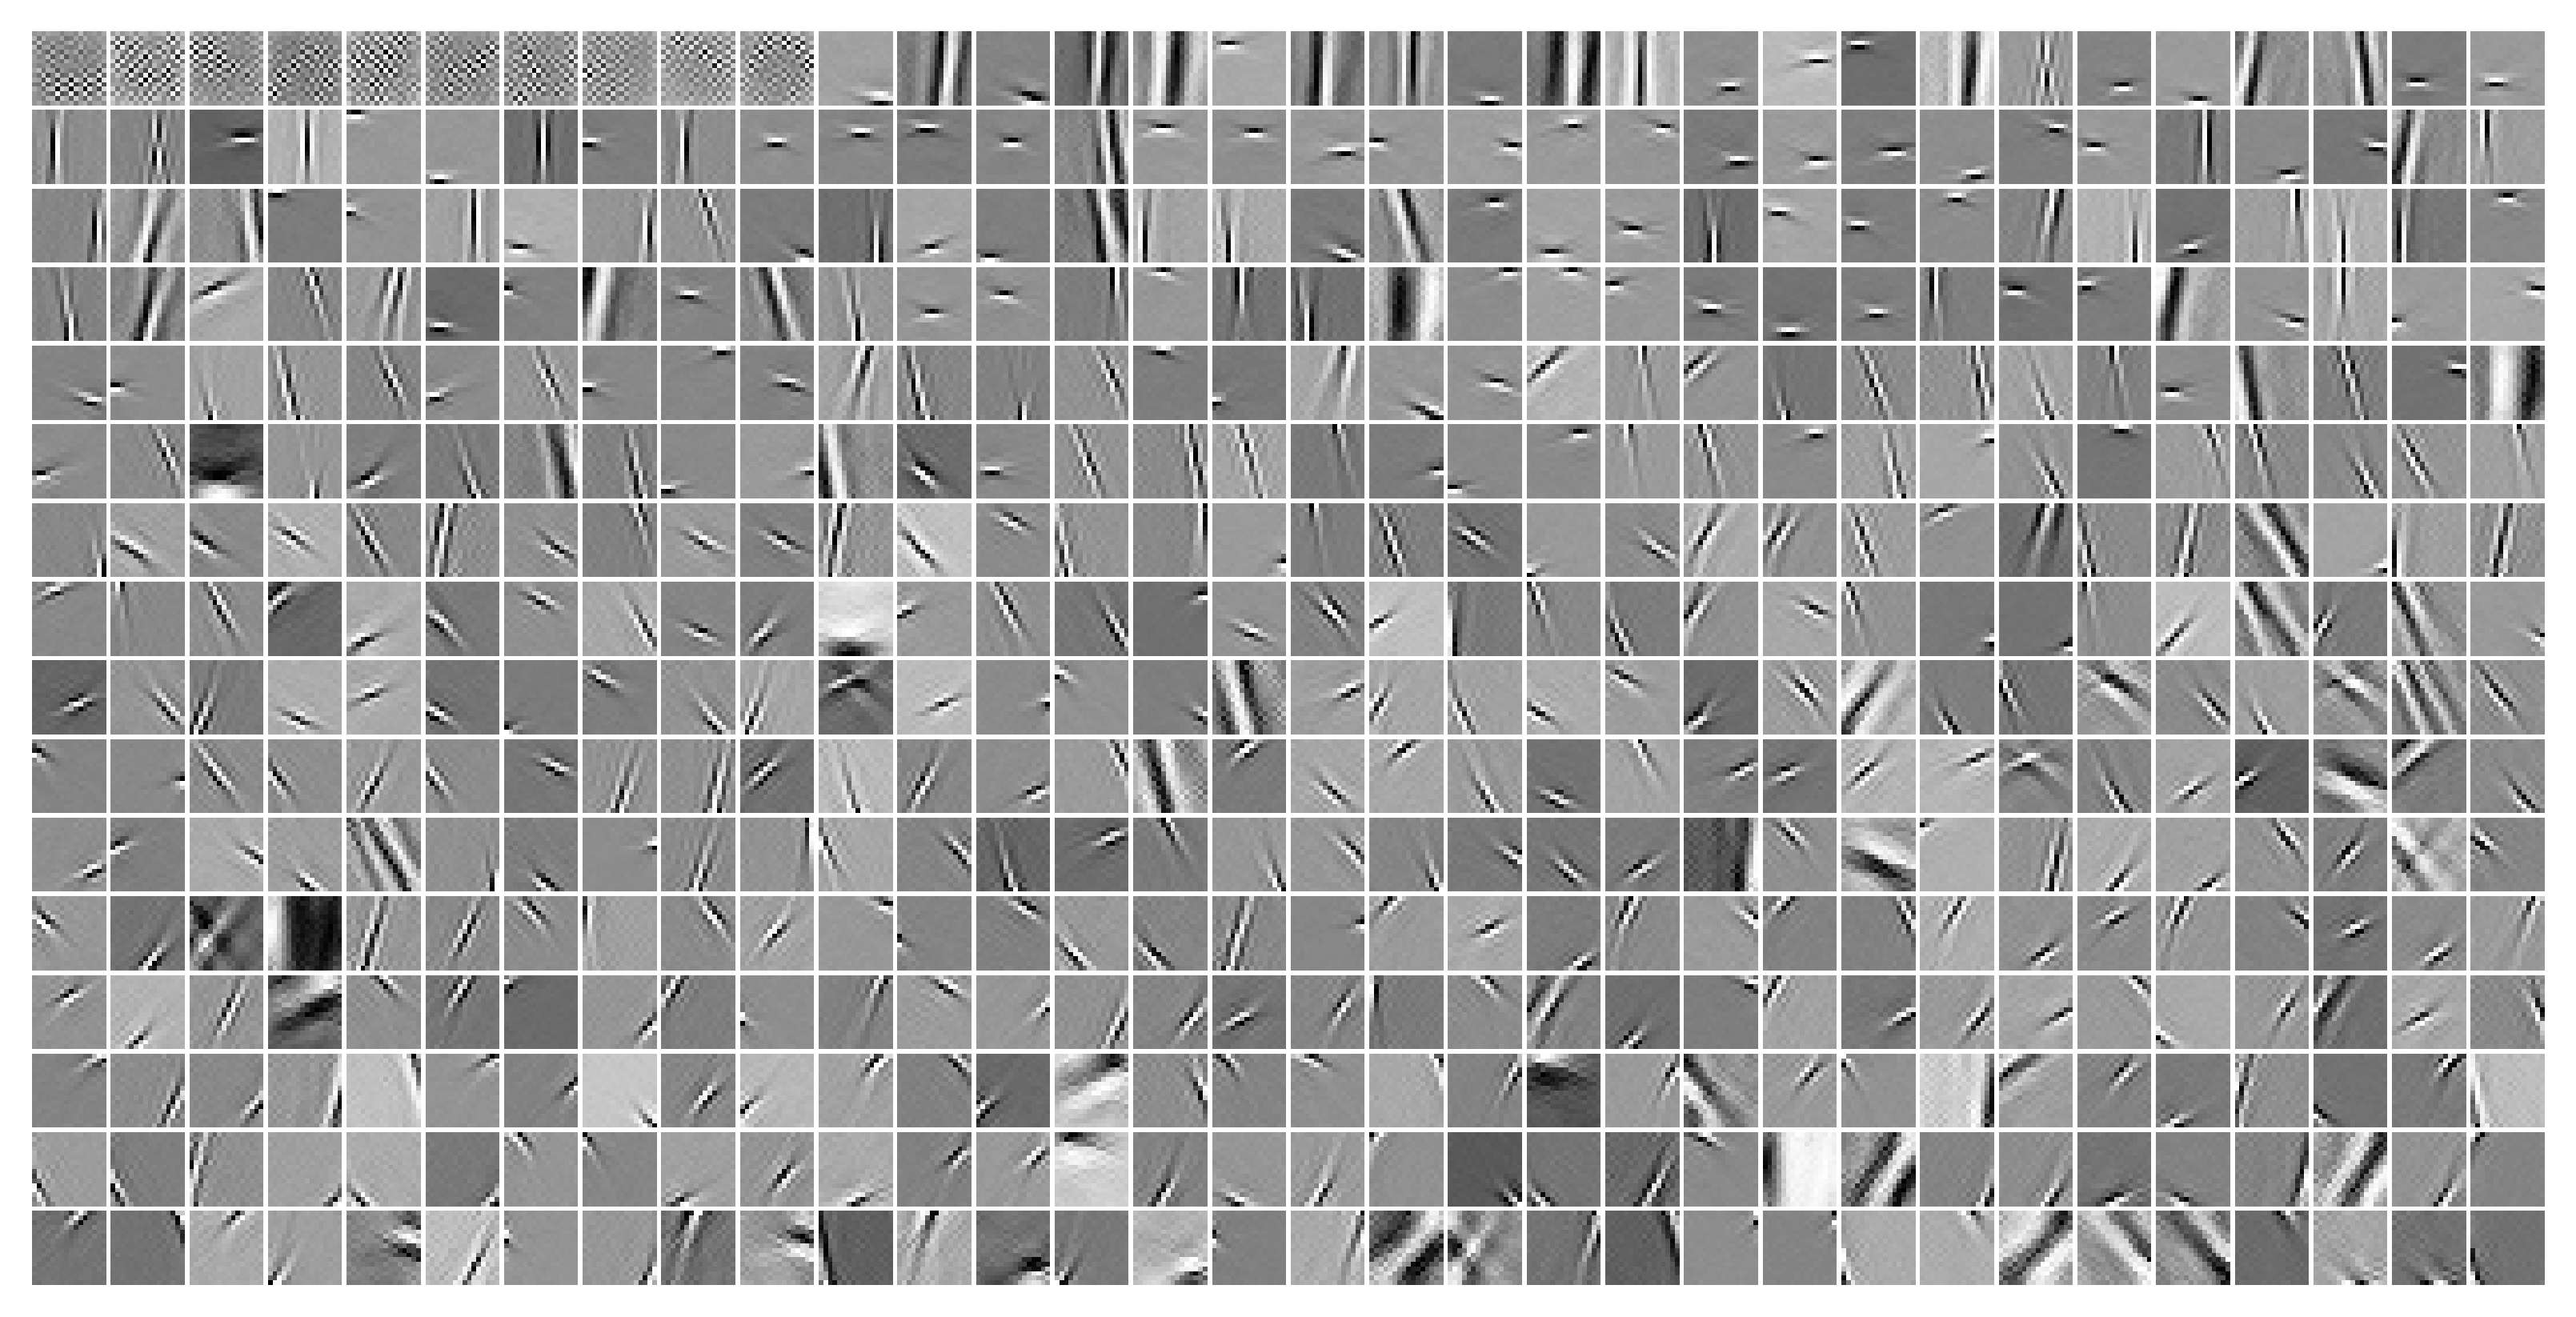

In [21]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

### High beta

$(T, \beta) = (64, 80.0)$

In [24]:
model_name = 'poisson_vH16_t-64_z-[512]_<jacob|lin>'
fit_name = 'b200-ep300-lr(0.002)_beta(80:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_09_13,20:54)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [25]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (64, 80.0))

In [26]:
print(tr.model.layer.n_exp)

tensor([ 18,  21,  26,  31,  37,  44,  52,  60,  69,  77,  85,  92,  98, 102,
        105, 108, 110, 111, 112, 113, 114, 114, 114, 114, 114, 114, 114, 114,
        114, 114, 114, 114, 114, 114, 113, 113, 113, 113, 113, 113, 113, 113,
        113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113,
        113, 113, 113, 113, 113, 113, 113, 113], device='cuda:0',
       dtype=torch.int32)

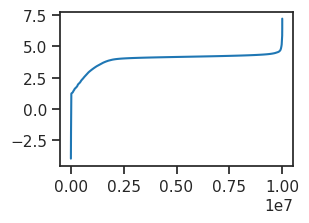

In [27]:
plt.plot(sorted(tr.model.stats['u_max']))

In [28]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

u_max.max(), du_max.max()

(7.220954418182373, 2.0157055854797363)

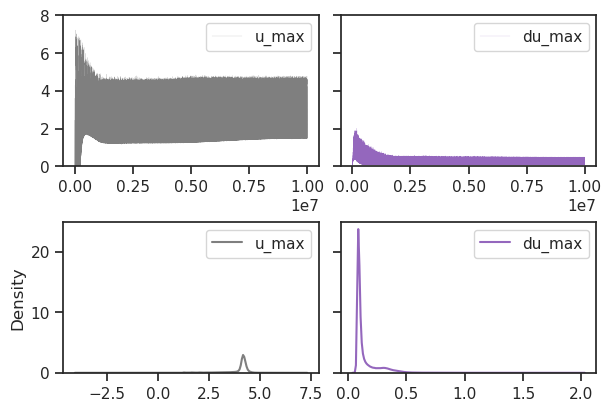

In [29]:
fig, axes = create_figure(2, 2, sharey='row')

axes[0, 0].plot(u_max, color='C7', lw=0.1, label='u_max')
axes[0, 1].plot(du_max, color='C4', lw=0.1, label='du_max')
axes[0, 1].set(ylim=(0, 8))

sns.kdeplot(u_max, color='C7', label='u_max', ax=axes[1, 0])
sns.kdeplot(du_max, color='C4', label='du_max', ax=axes[1, 1])

add_legend(axes)
plt.show()

In [30]:
grad = np.array(list(tr.stats['grad'].values()))
(grad > tr.cfg.grad_clip).sum(), np.round((grad > tr.cfg.grad_clip).mean(), 3)

(10, 0.0)

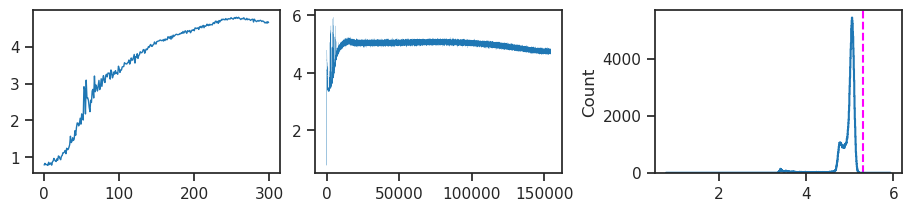

In [31]:
fig, axes = create_figure(1, 3)

axes[0].plot(np.log(grad)[:300], lw=1)
axes[1].plot(np.log(grad), lw=0.1)

axes[2].axvline(np.log(tr.cfg.grad_clip), color='magenta', ls='--')
histplot(np.log(grad), ax=axes[2])

plt.show()

100%|███████████████████████████████████| 2/2 [00:56<00:00, 28.09s/it]


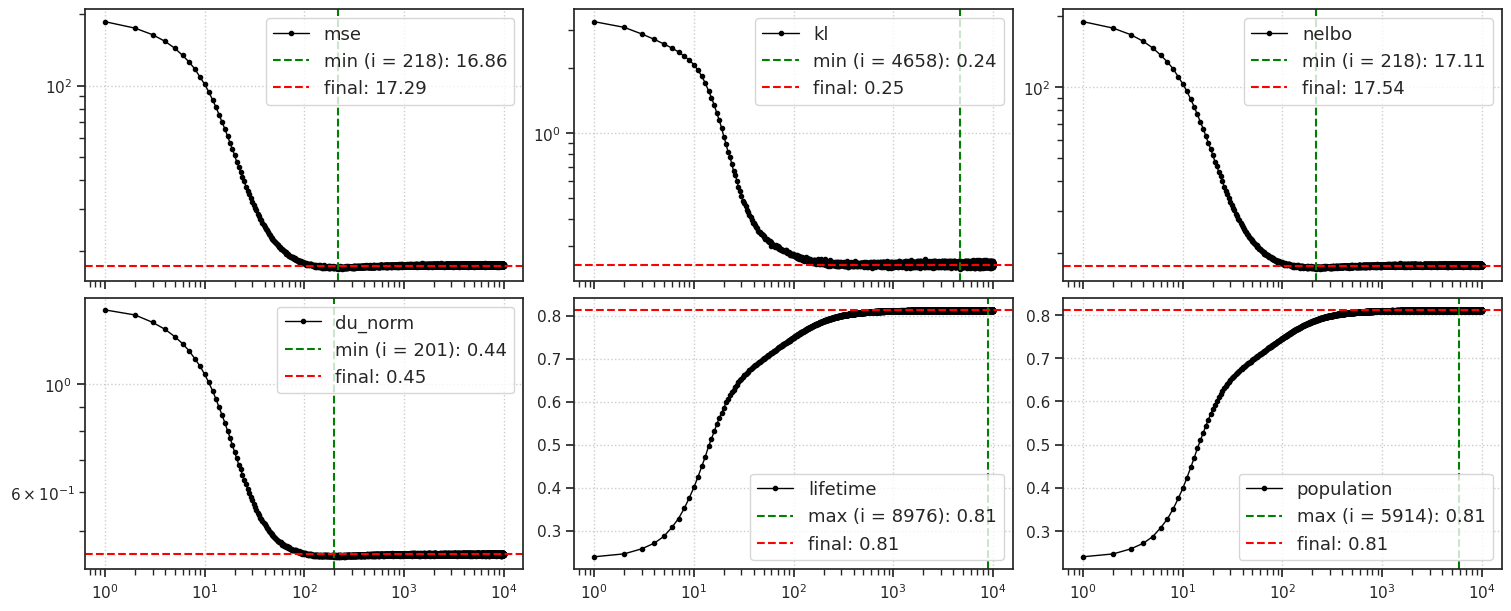

In [32]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=2,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

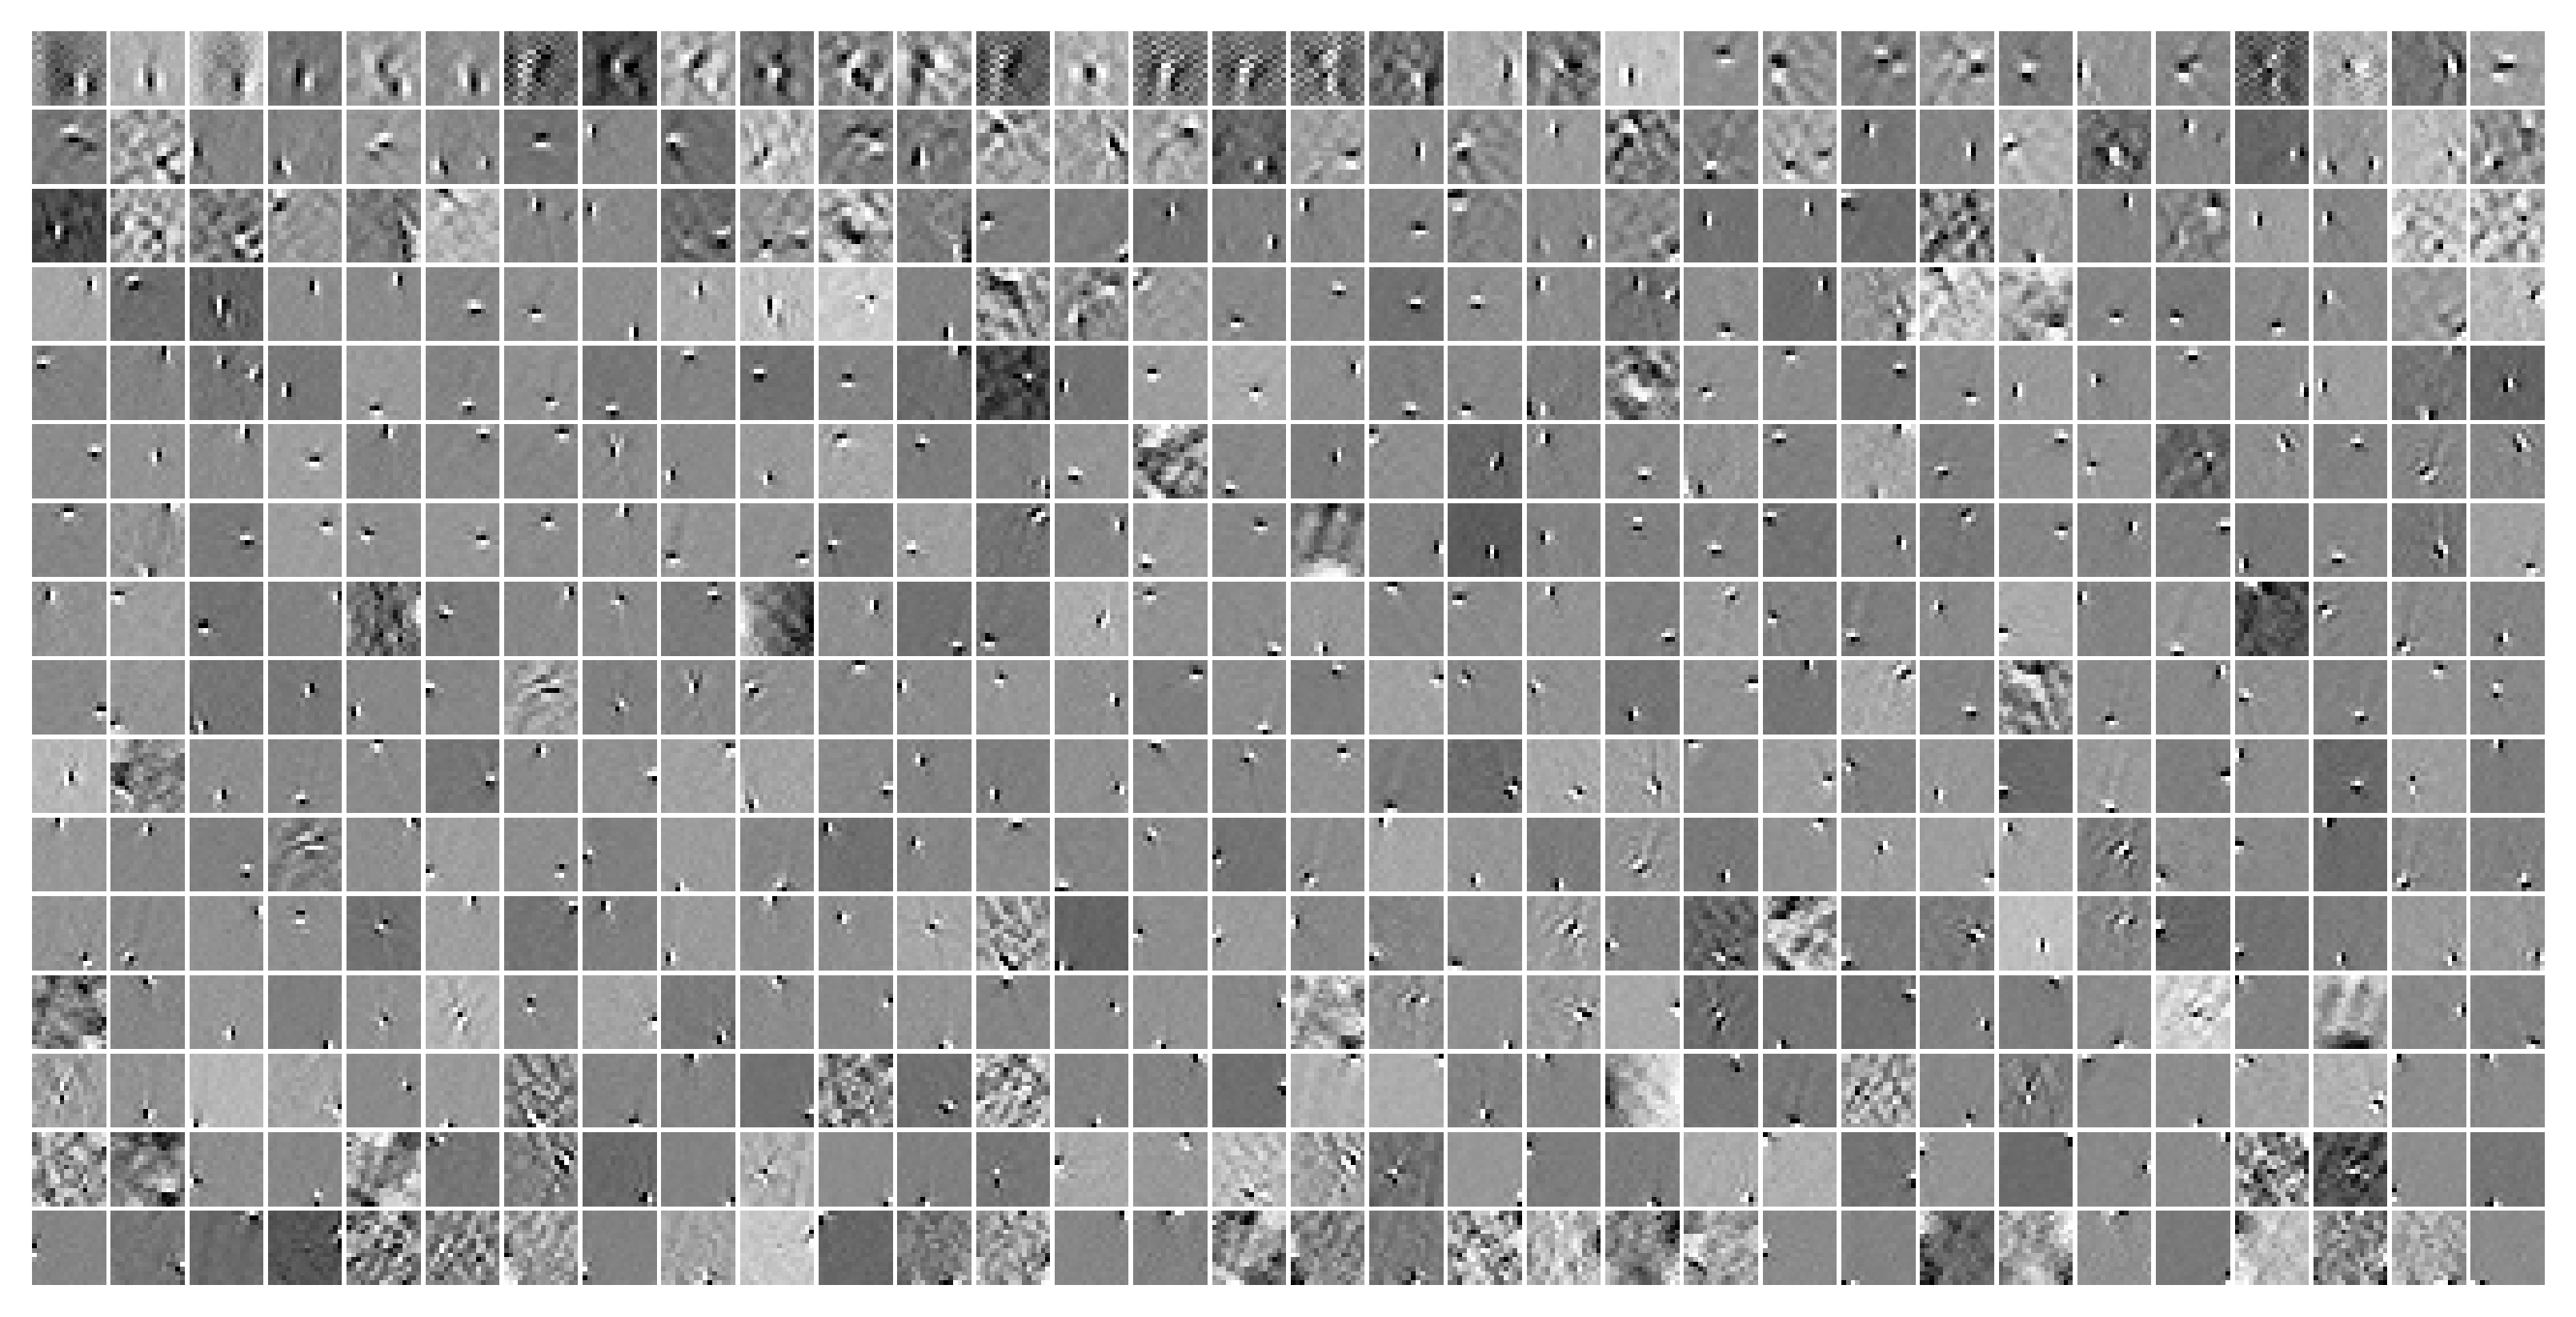

In [33]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

### Really high beta

$(T, \beta) = (64, 96.0)$

In [34]:
model_name = 'poisson_vH16_t-64_z-[512]_<jacob|lin>'
fit_name = 'b200-ep300-lr(0.002)_beta(96:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_09_14,00:00)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [35]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (64, 96.0))

In [36]:
print(tr.model.layer.n_exp)

tensor([ 16,  18,  21,  25,  30,  35,  41,  47,  54,  61,  68,  74,  80,  85,
         89,  92,  95,  96,  98,  99, 100, 100, 100, 101, 101, 101, 101, 101,
        101, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99], device='cuda:0',
       dtype=torch.int32)

100%|███████████████████████████████████| 2/2 [00:52<00:00, 26.01s/it]


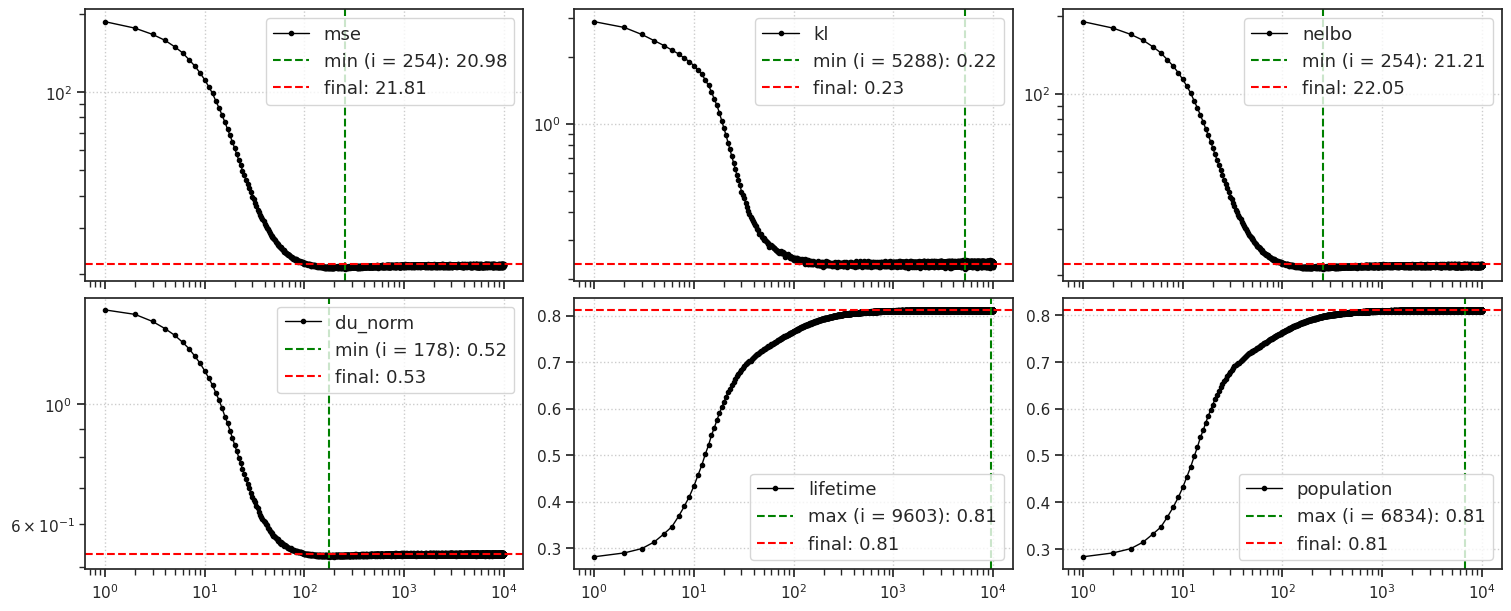

In [38]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=2,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

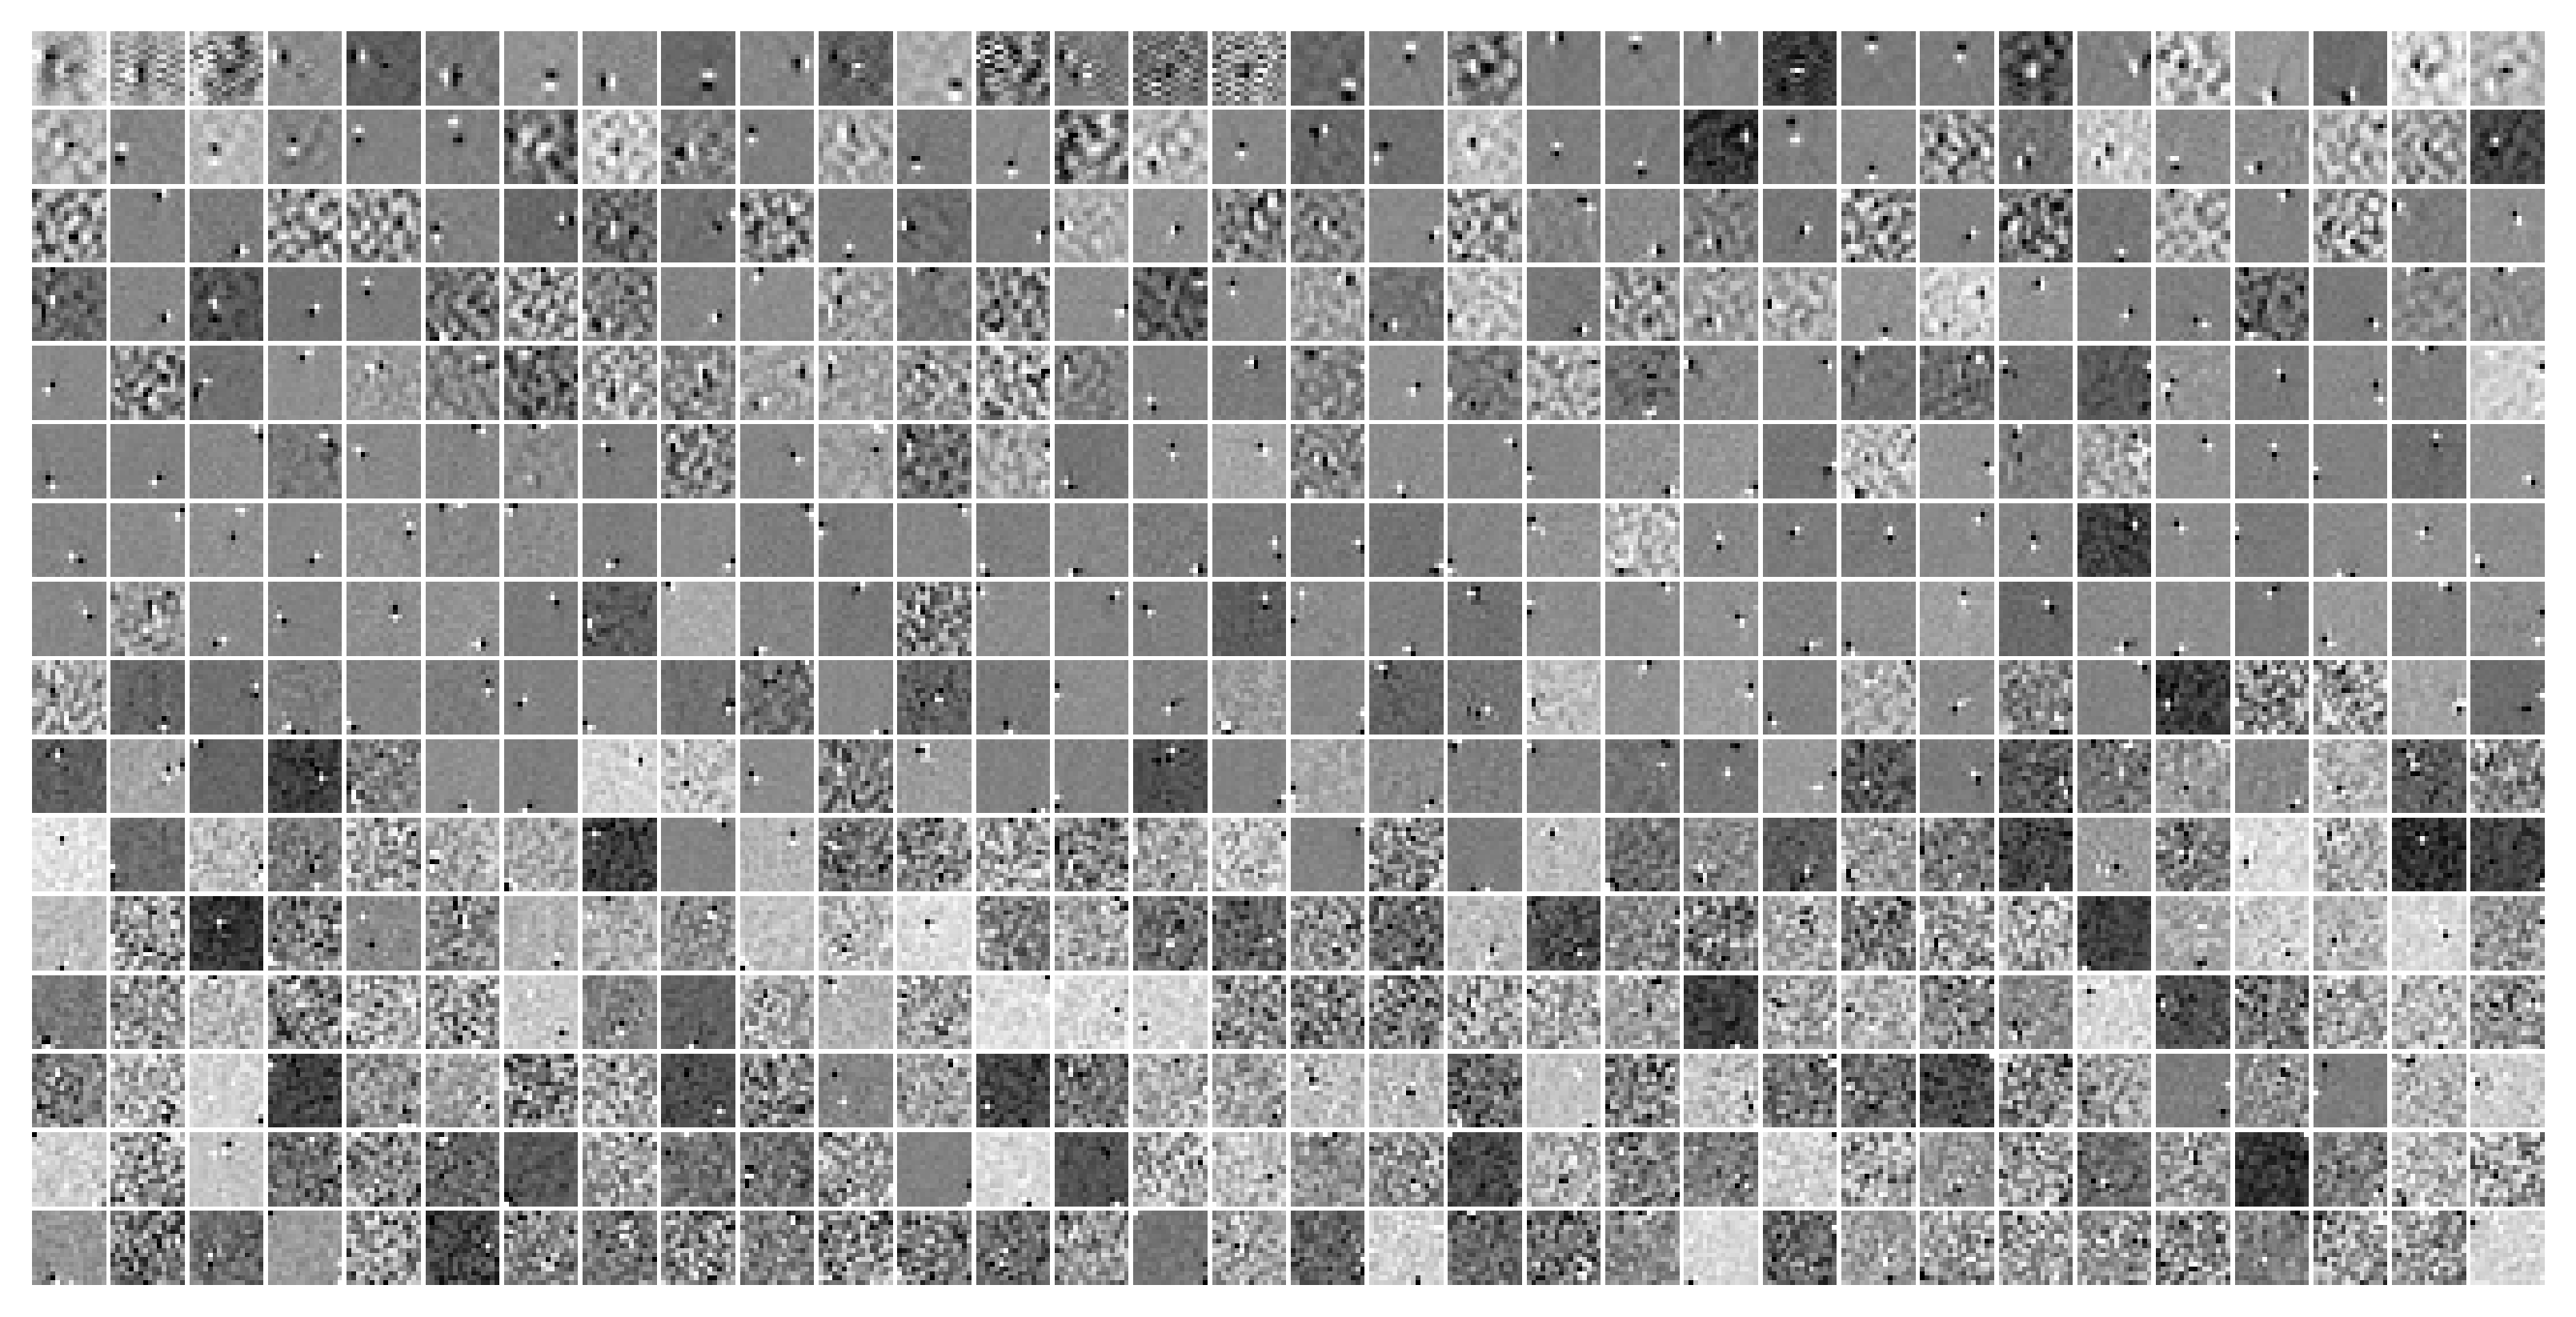

In [39]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

## vH16

$T = 32$

### Medium beta

$(T, \beta) = (32, 16.0)$

In [40]:
model_name = 'poisson_vH16_t-32_z-[512]_<jacob|lin>'
fit_name = 'u:(8.0)-du:(7.0)_b200-ep300-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_09_12,22:30)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [41]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (32, 16.0))

In [42]:
print(tr.model.layer.n_exp)

tensor([ 27,  41,  60,  84, 107, 125, 135, 140, 143, 143, 144, 143, 143, 143,
        143, 142, 142, 142, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,
        141, 141, 140, 140], device='cuda:0', dtype=torch.int32)

100%|███████████████████████████████████| 2/2 [00:52<00:00, 26.08s/it]


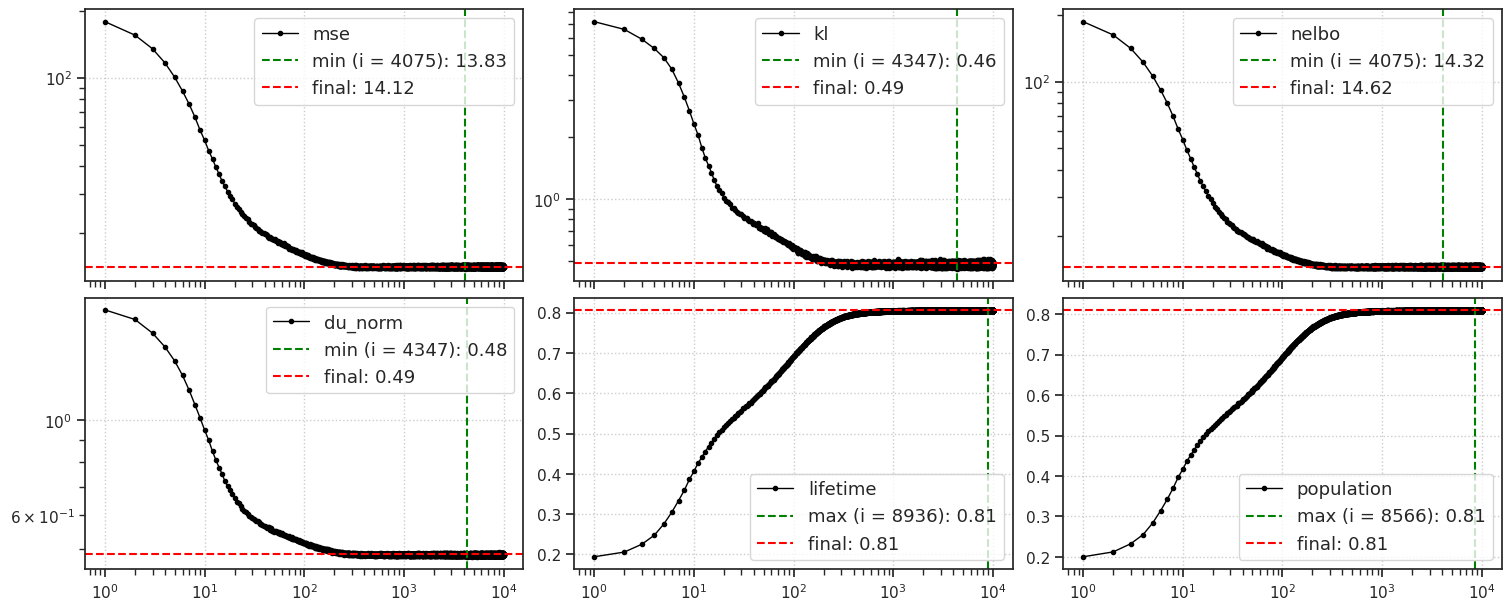

In [43]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=2,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

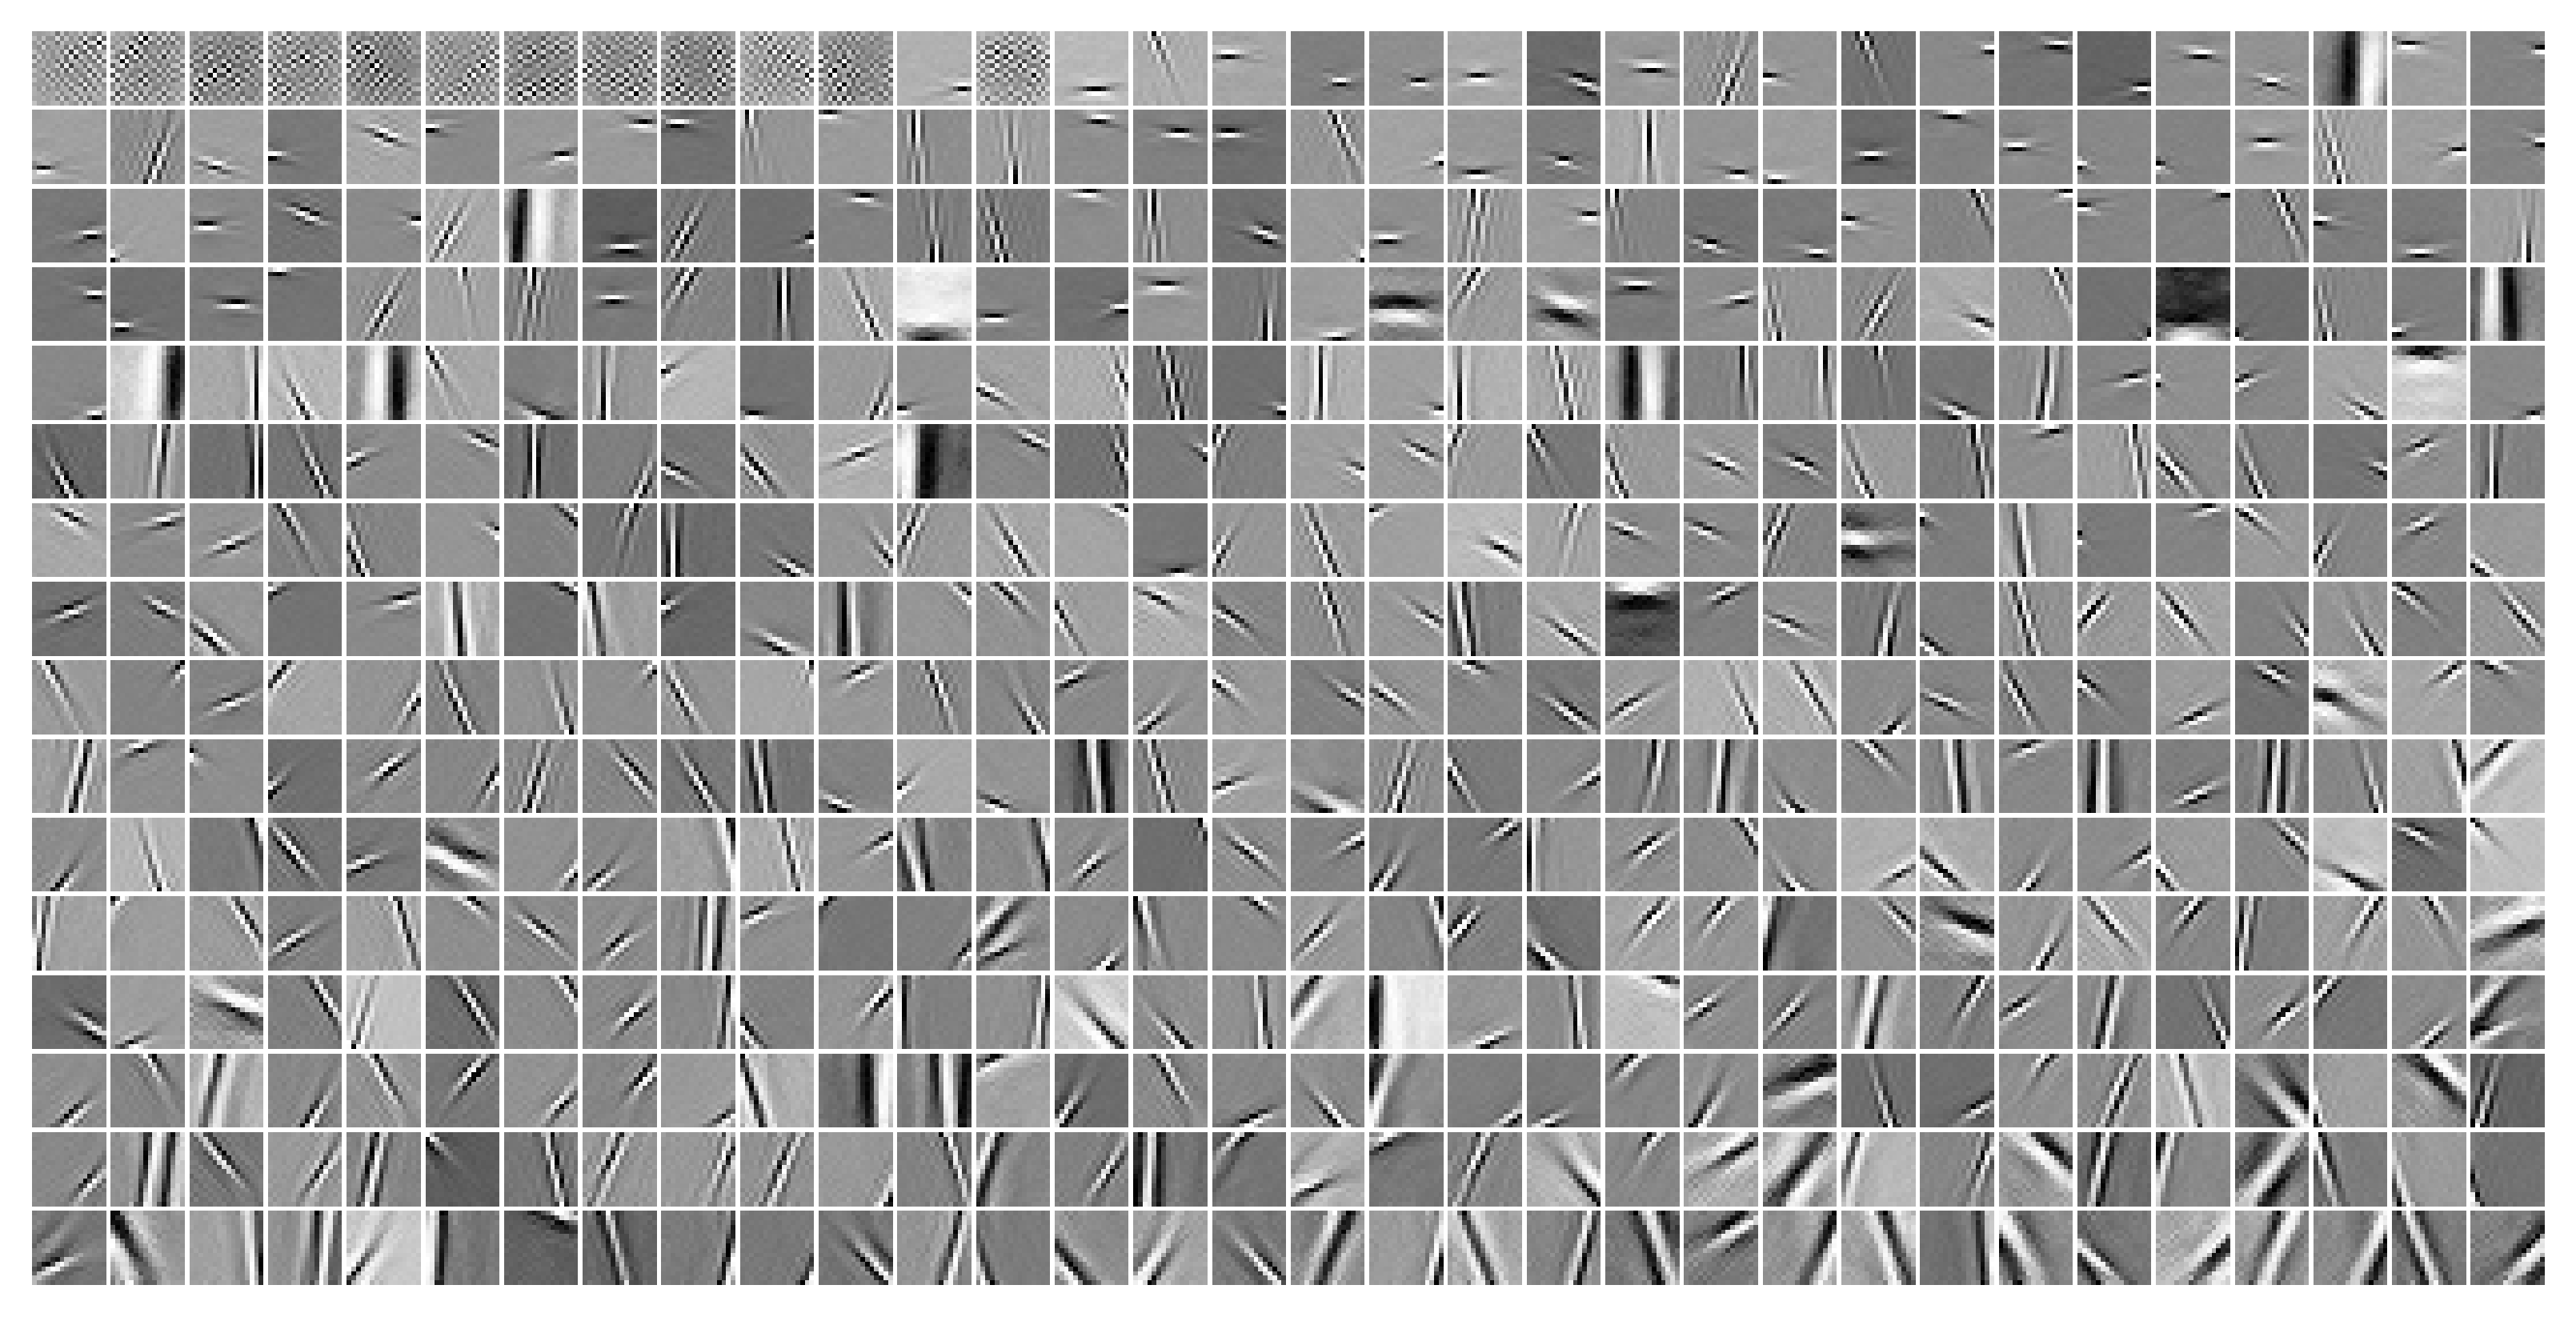

In [44]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

### High beta

$(T, \beta) = (32, 32.0)$

In [45]:
model_name = 'poisson_vH16_t-32_z-[512]_<jacob|lin>'
fit_name = 'u:(8.0)-du:(7.0)_b200-ep300-lr(0.002)_beta(32:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_09_12,22:59)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [46]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (32, 32.0))

In [47]:
print(tr.model.layer.n_exp)

tensor([ 22,  31,  44,  61,  80,  99, 114, 124, 129, 133, 133, 134, 134, 134,
        134, 133, 133, 133, 133, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132], device='cuda:0', dtype=torch.int32)

100%|███████████████████████████████████| 2/2 [00:52<00:00, 26.32s/it]


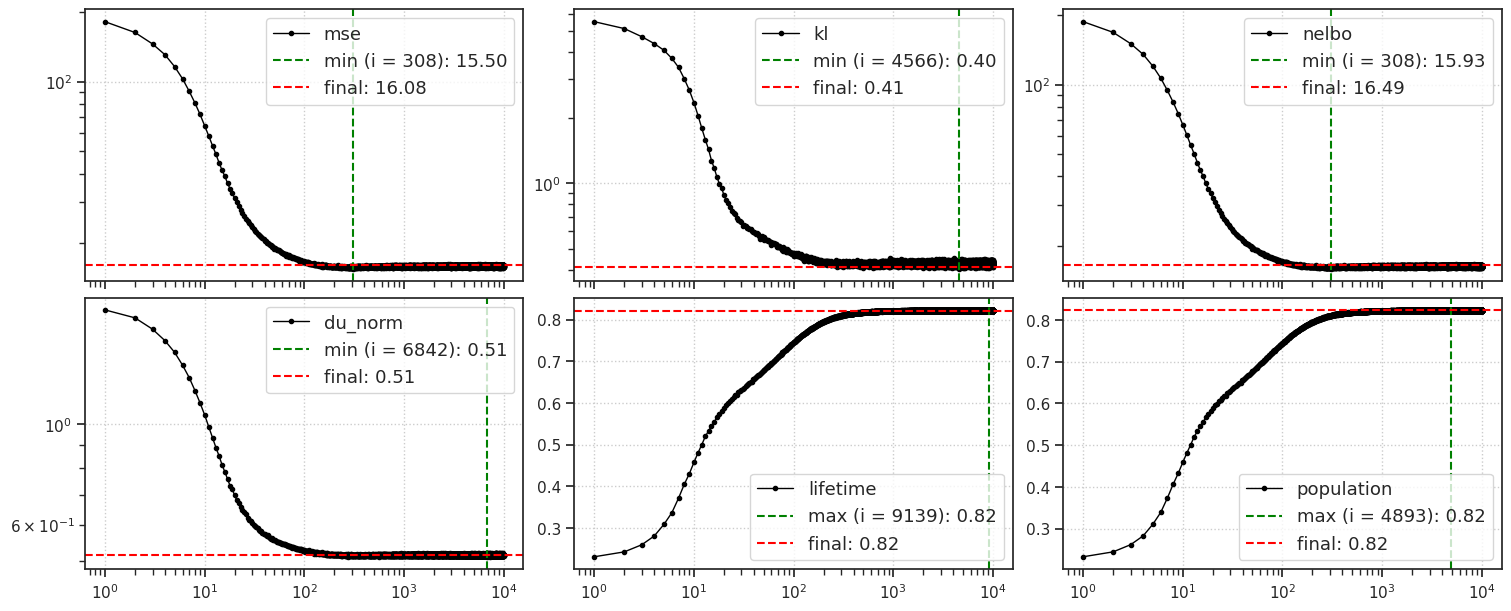

In [48]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=2,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

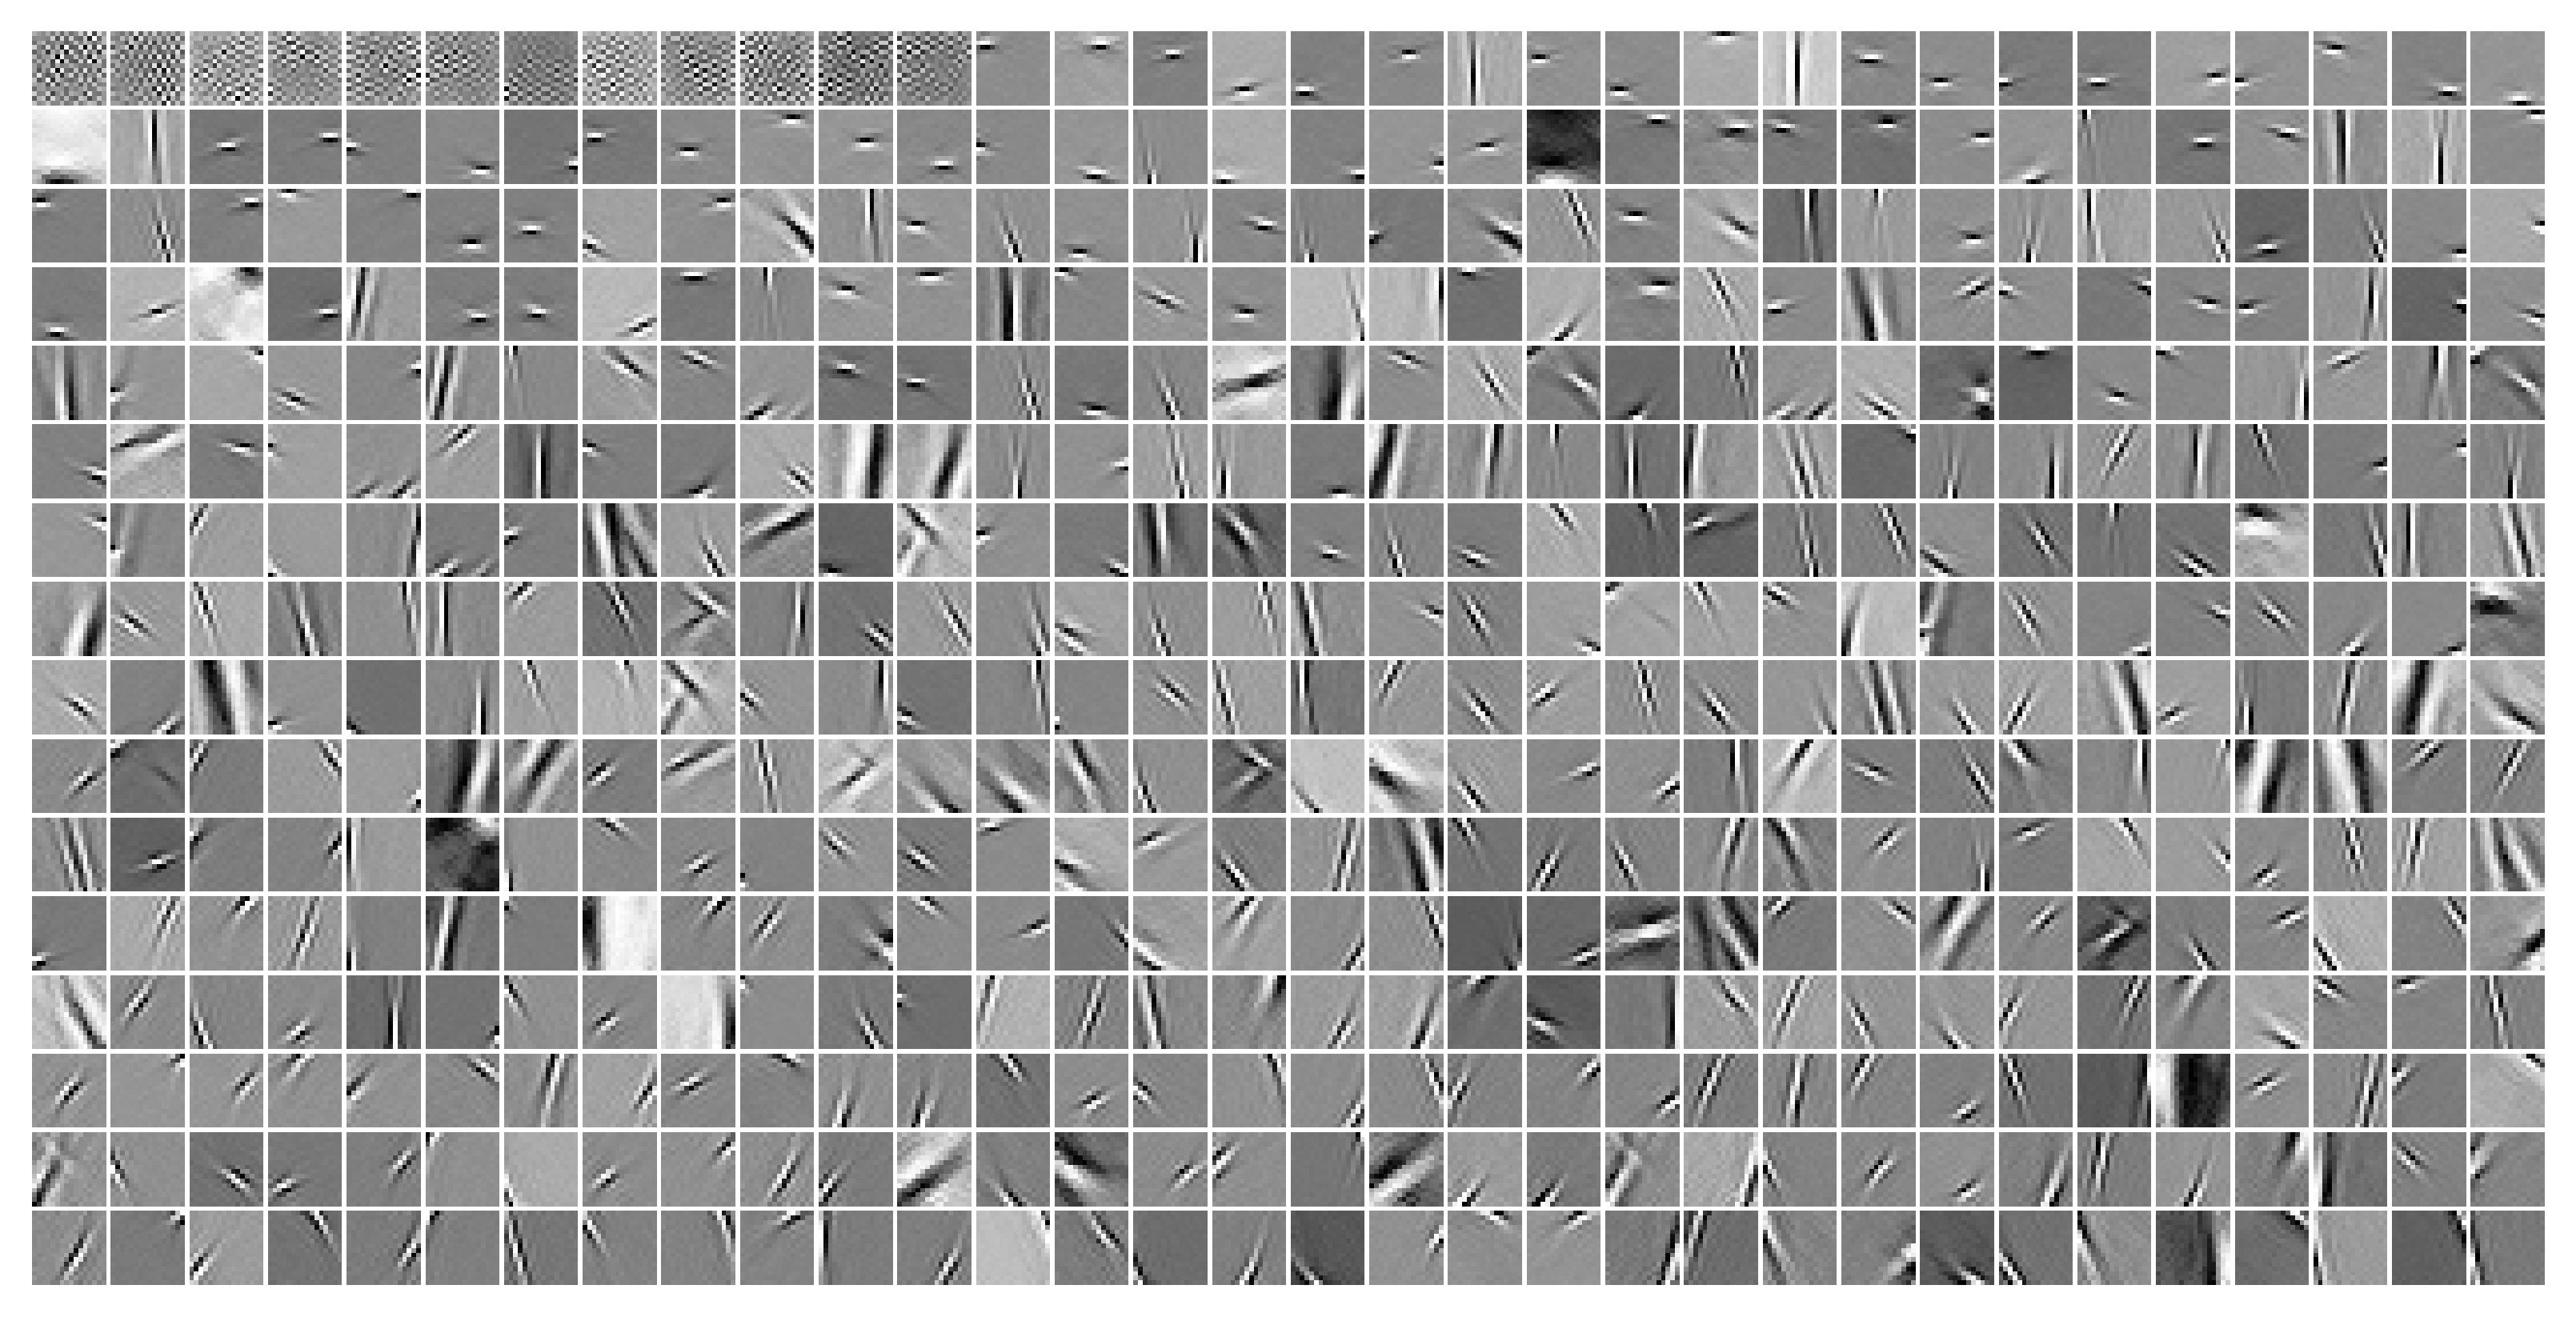

In [49]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

## vH16

$T = 8$

### Medium beta

$(T, \beta) = (8, 4.0)$

Fit $\#1$

In [51]:
model_name = 'poisson_vH16_t-8_z-[512]_<jacob|lin>'
fit_name = 'u:(8.0)-du:(7.0)_b200-ep300-lr(0.002)_beta(4:0x0.1)_temp(0.05:lin-0.5)_gr(500)_(2024_09_12,20:27)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [52]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (8, 4.0))

In [53]:
print(tr.model.layer.n_exp)

tensor([32, 60, 87, 94, 94, 94, 93, 94], device='cuda:0', dtype=torch.int32)

100%|█████████████████████████████████| 10/10 [05:03<00:00, 30.37s/it]


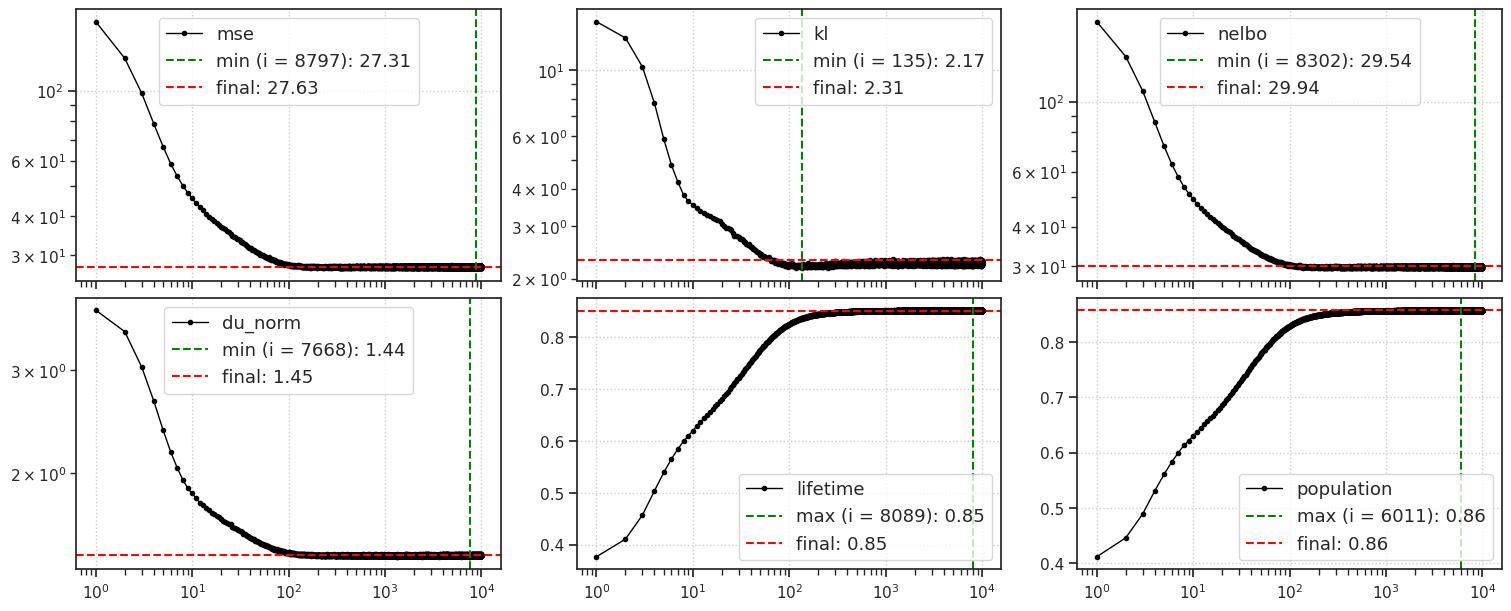

In [56]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=10,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

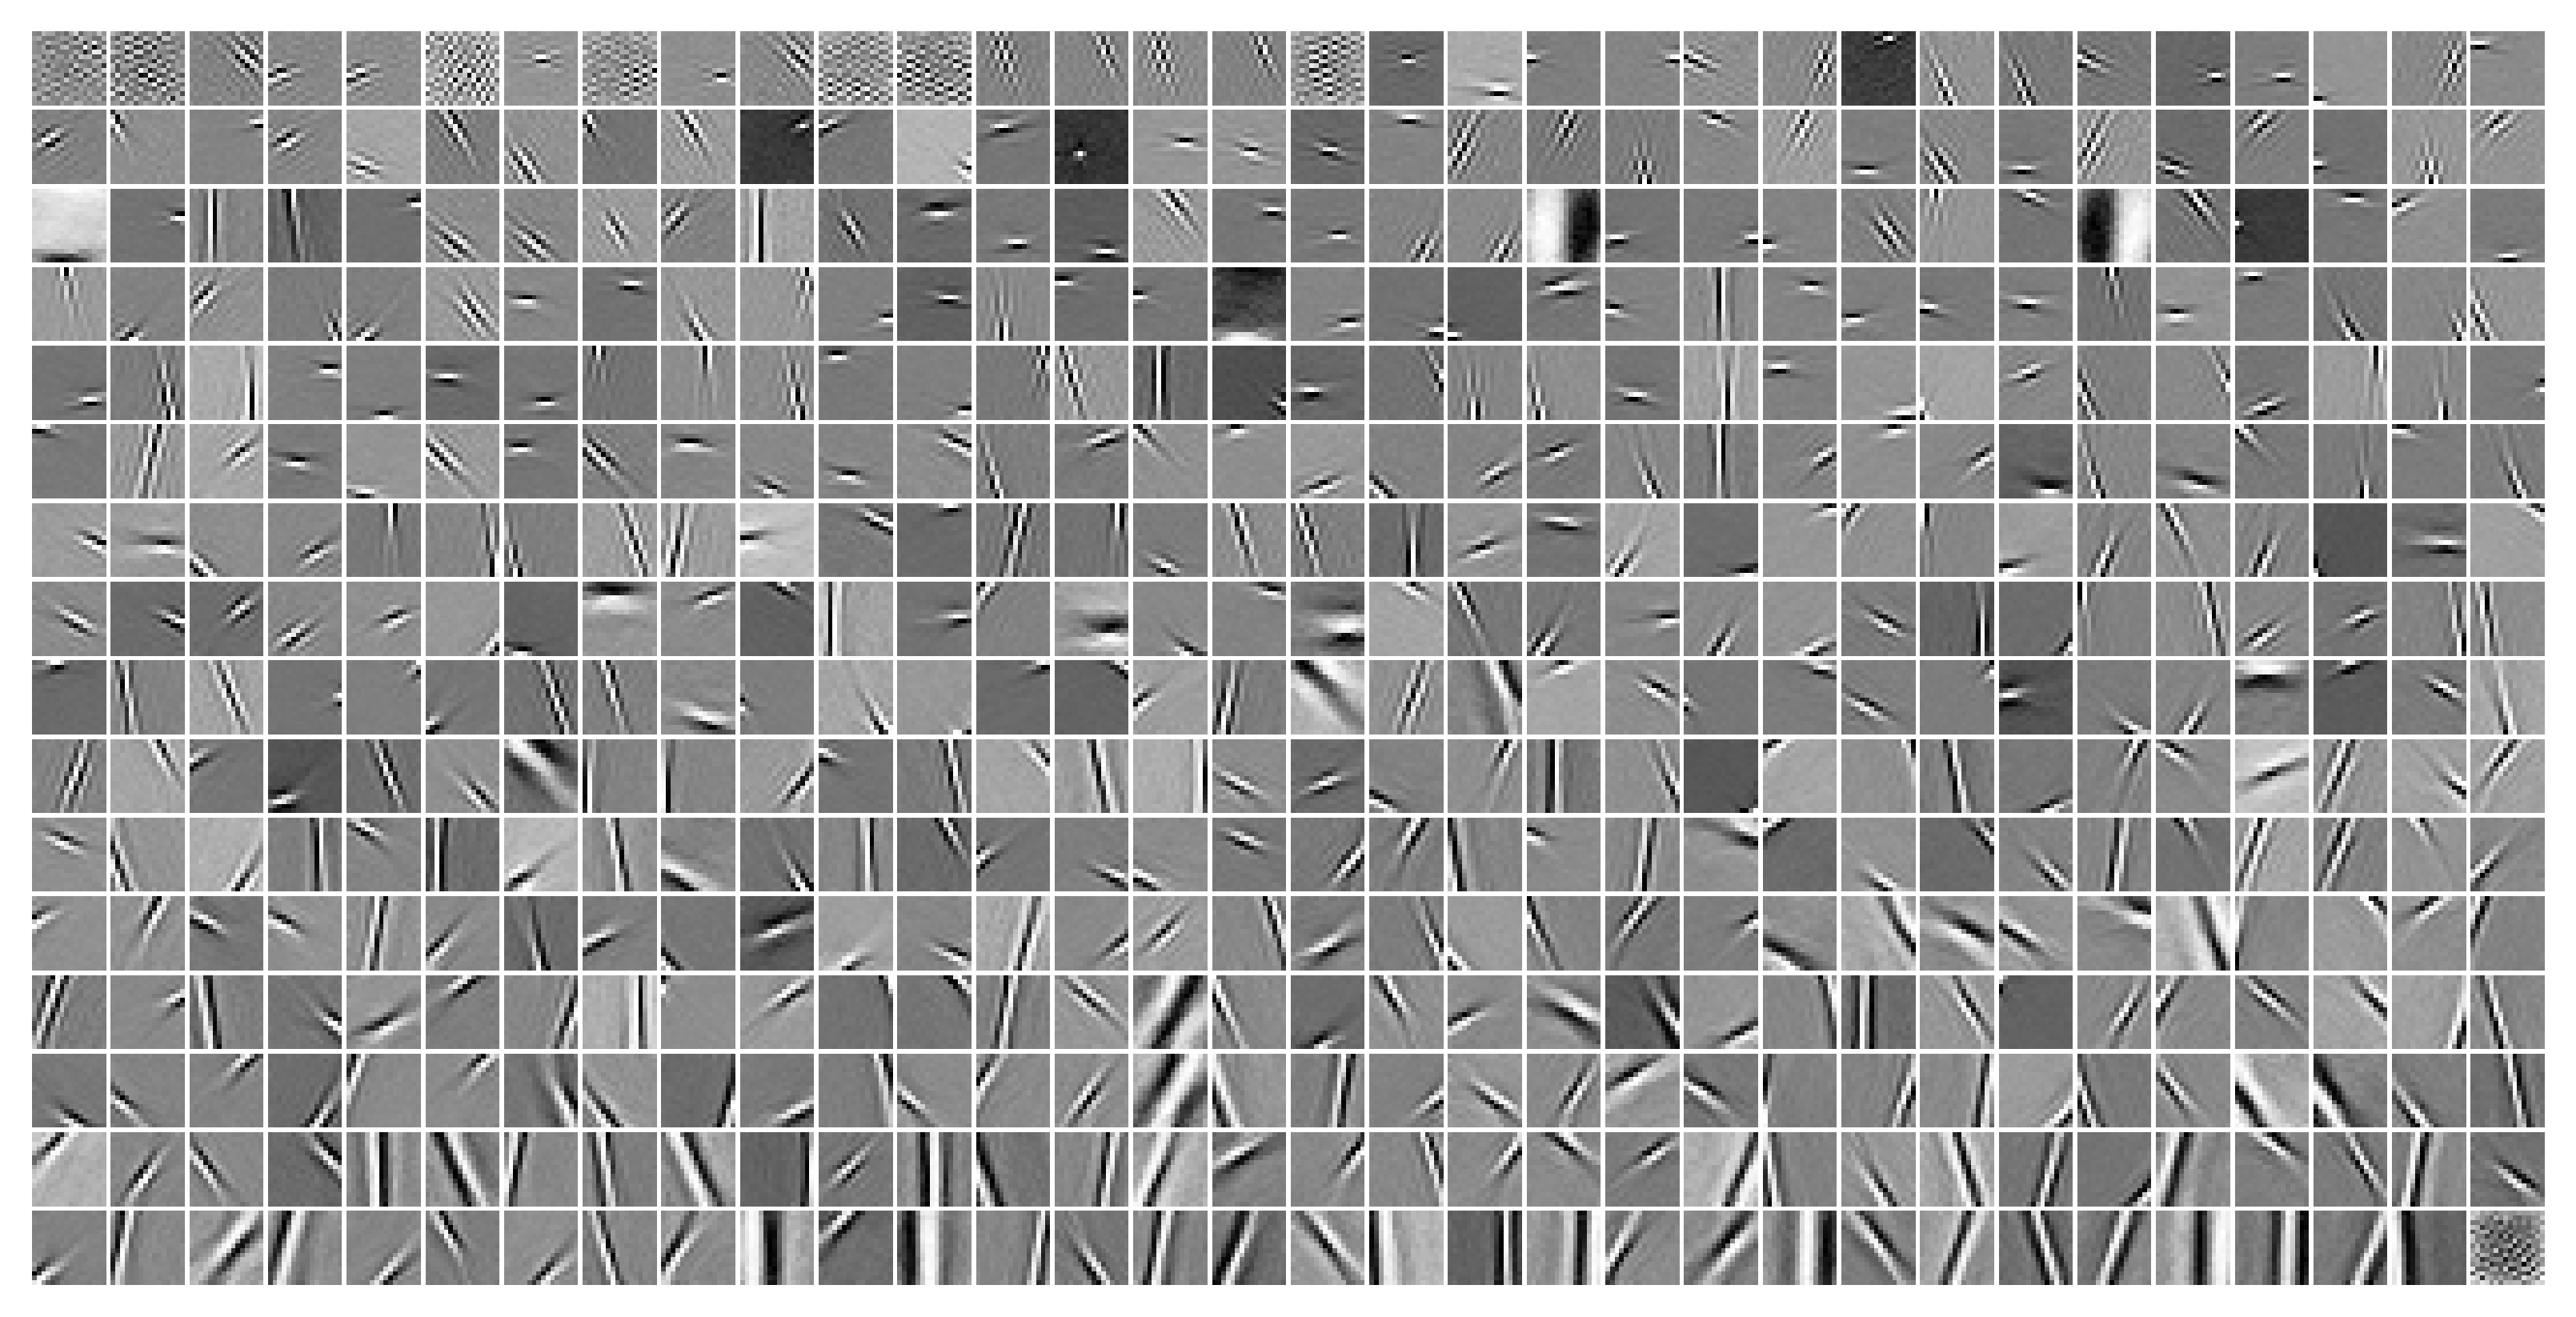

In [57]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

### Medium beta

$(T, \beta) = (8, 4.0)$

Fit $\#2$

In [58]:
model_name = 'poisson_vH16_t-8_z-[512]_<jacob|lin>'
fit_name = 'u:(8.0)-du:(7.0)_b200-ep300-lr(0.002)_beta(4:0x0.1)_temp(0.05:lin-0.5)_gr(500)_(2024_09_12,20:03)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [59]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (8, 4.0))

In [60]:
print(tr.model.layer.n_exp)

tensor([30, 58, 85, 92, 93, 92, 92, 92], device='cuda:0', dtype=torch.int32)

100%|█████████████████████████████████| 10/10 [04:05<00:00, 24.55s/it]


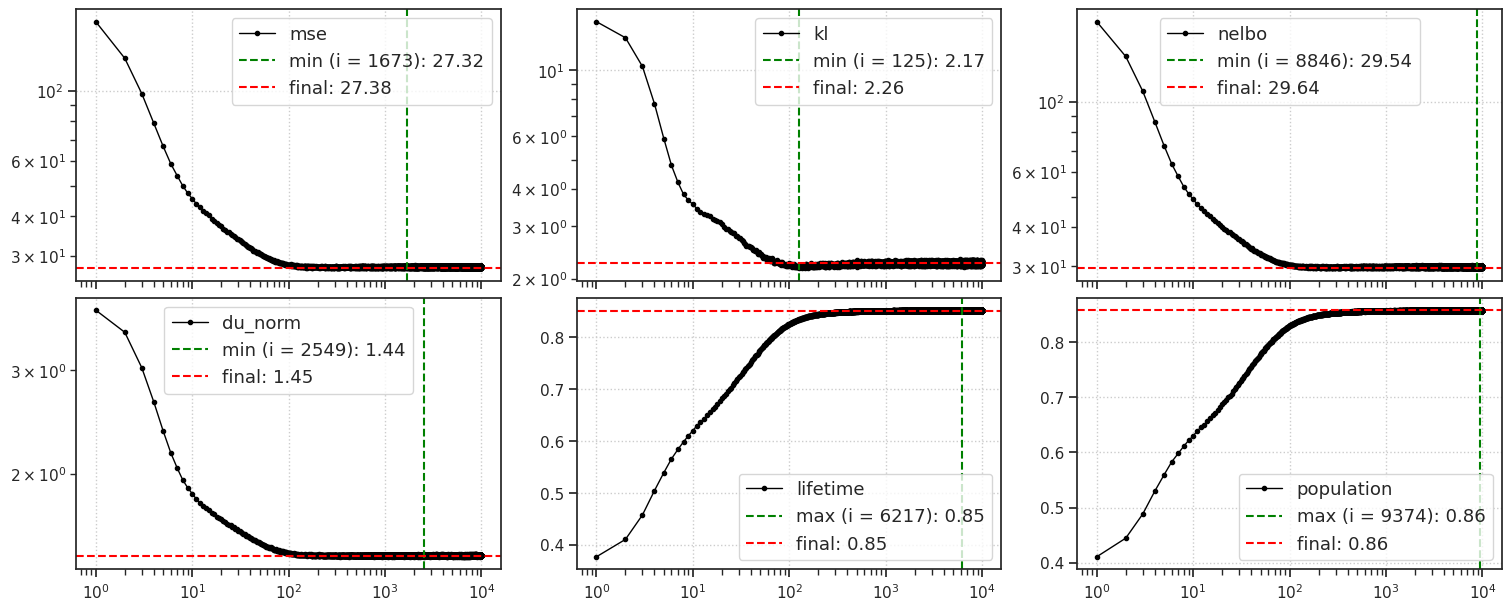

In [61]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=10,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

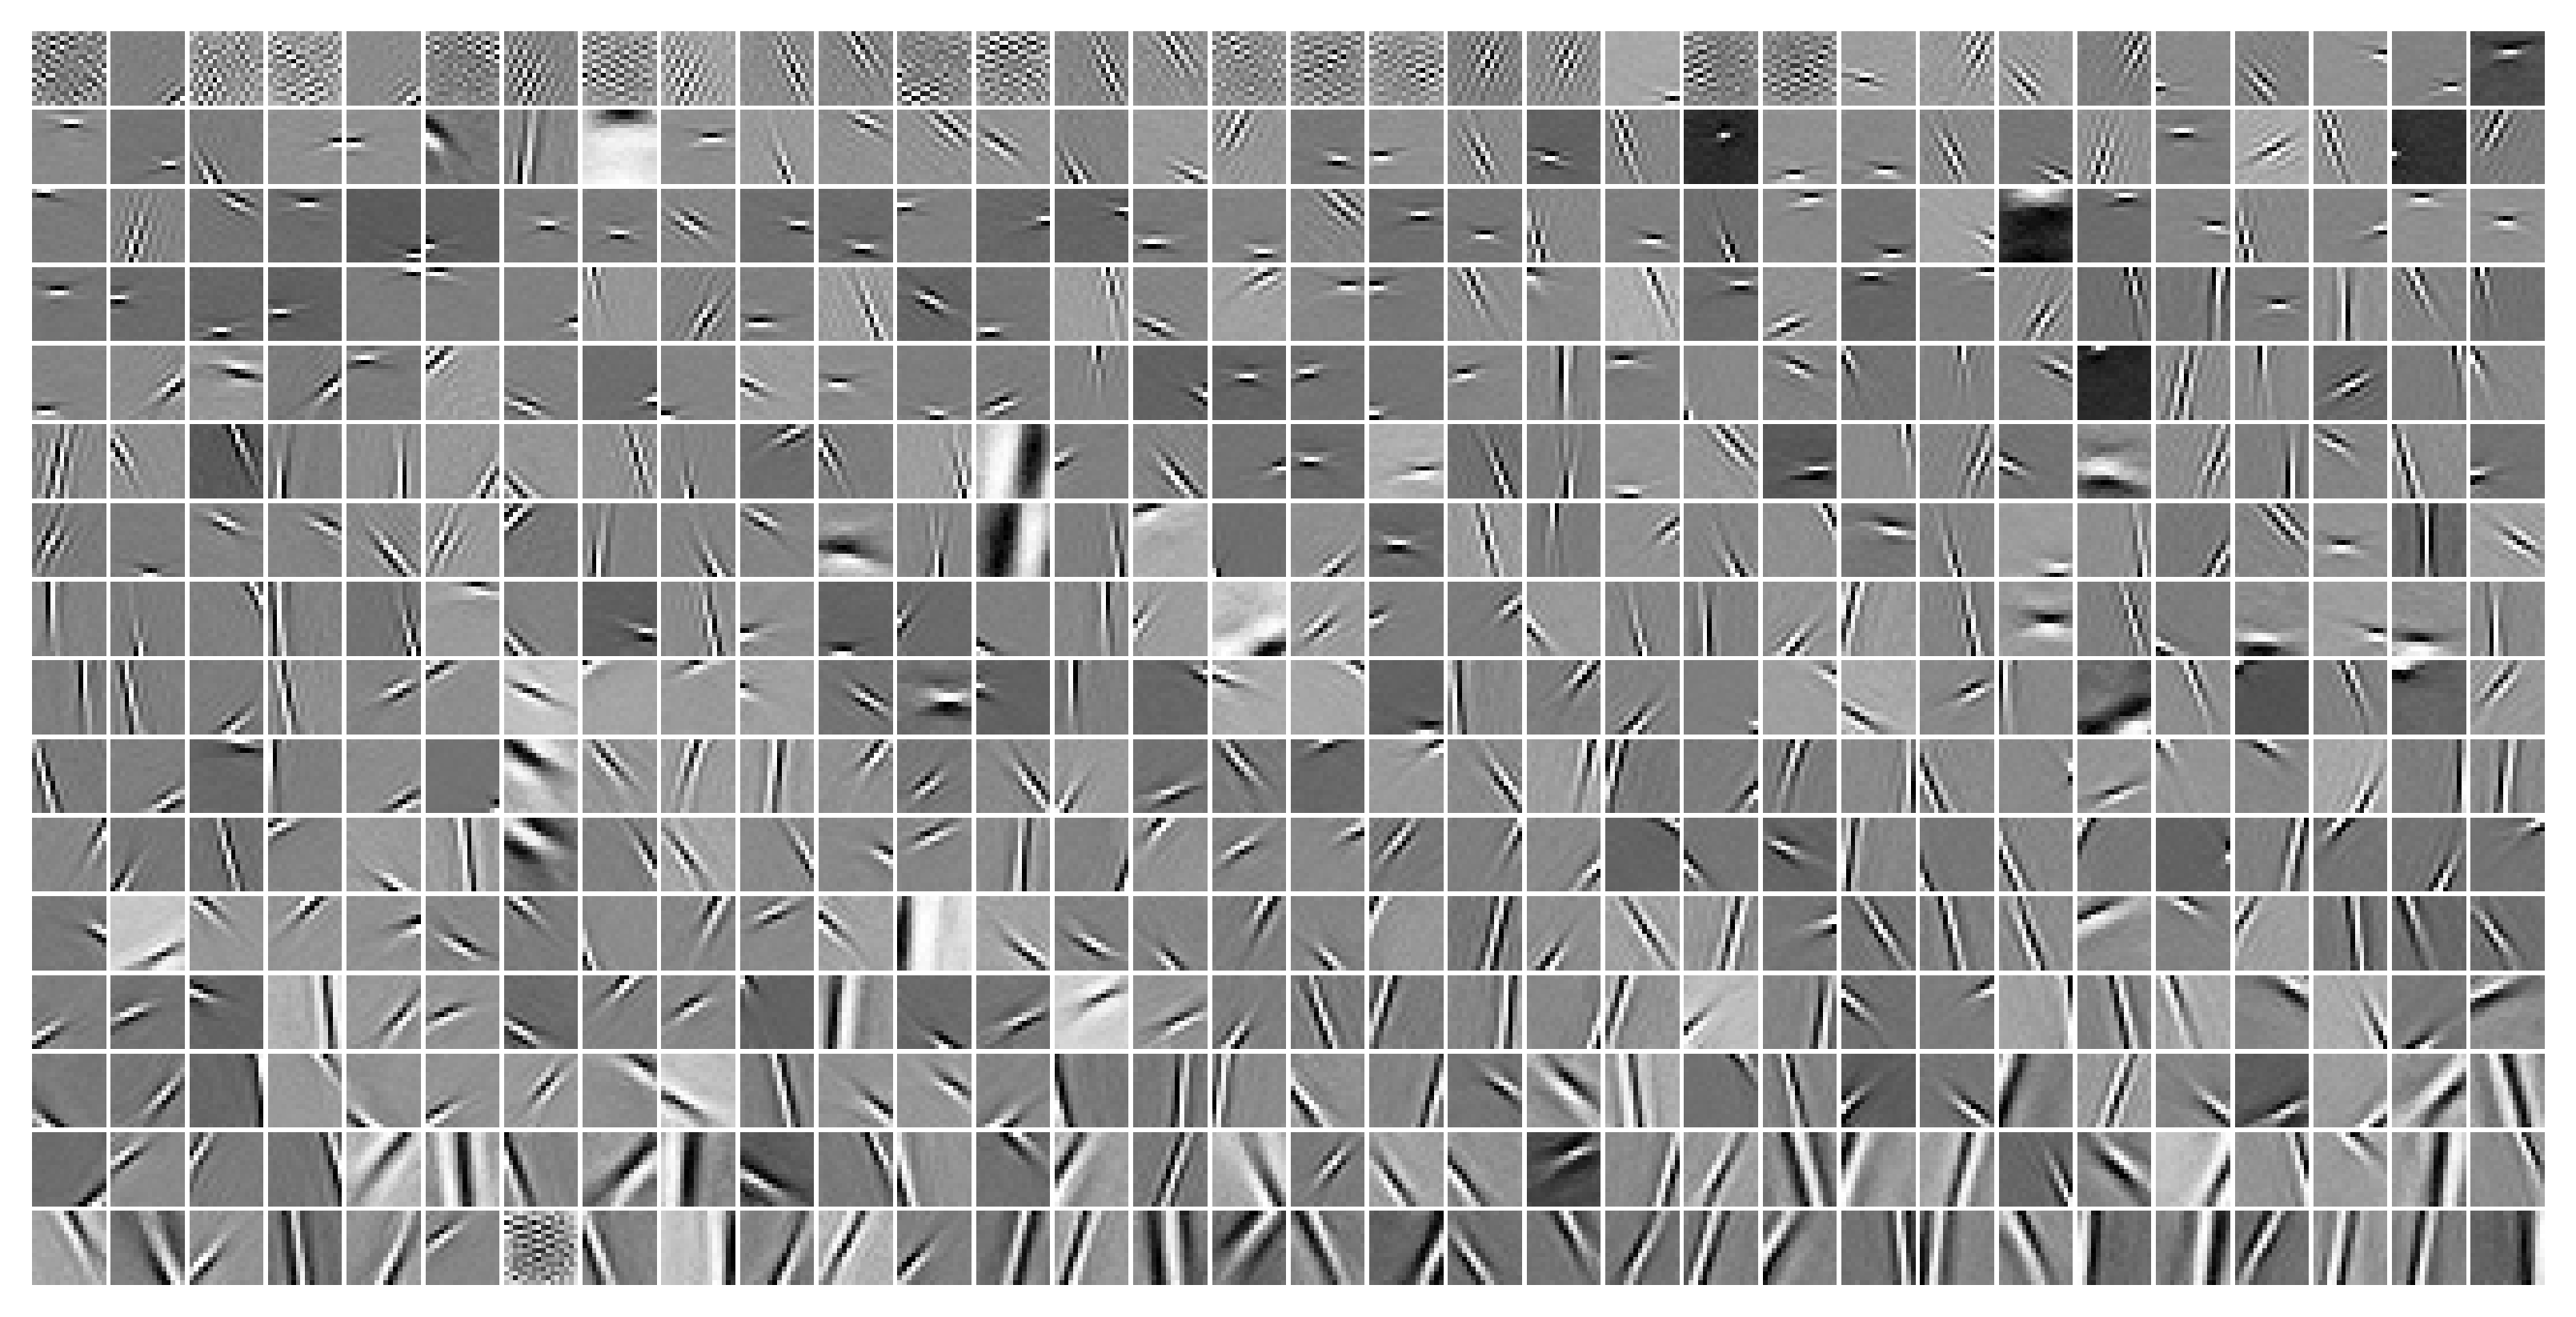

In [62]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

## vH16

$T = 4$

### Medium beta

$(T, \beta) = (4, 2.0)$

In [3]:
model_name = 'poisson_vH16_t-4_z-[512]_<jacob|lin>'
fit_name = 'b200-ep300-lr(0.002)_beta(2:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_09_24,01:01)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [4]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (4, 2.0))

In [5]:
print(tr.model.layer.n_exp)

tensor([34, 69, 76, 76], device='cuda:2', dtype=torch.int32)

100%|█████████████████████████████████| 50/50 [21:17<00:00, 25.55s/it]


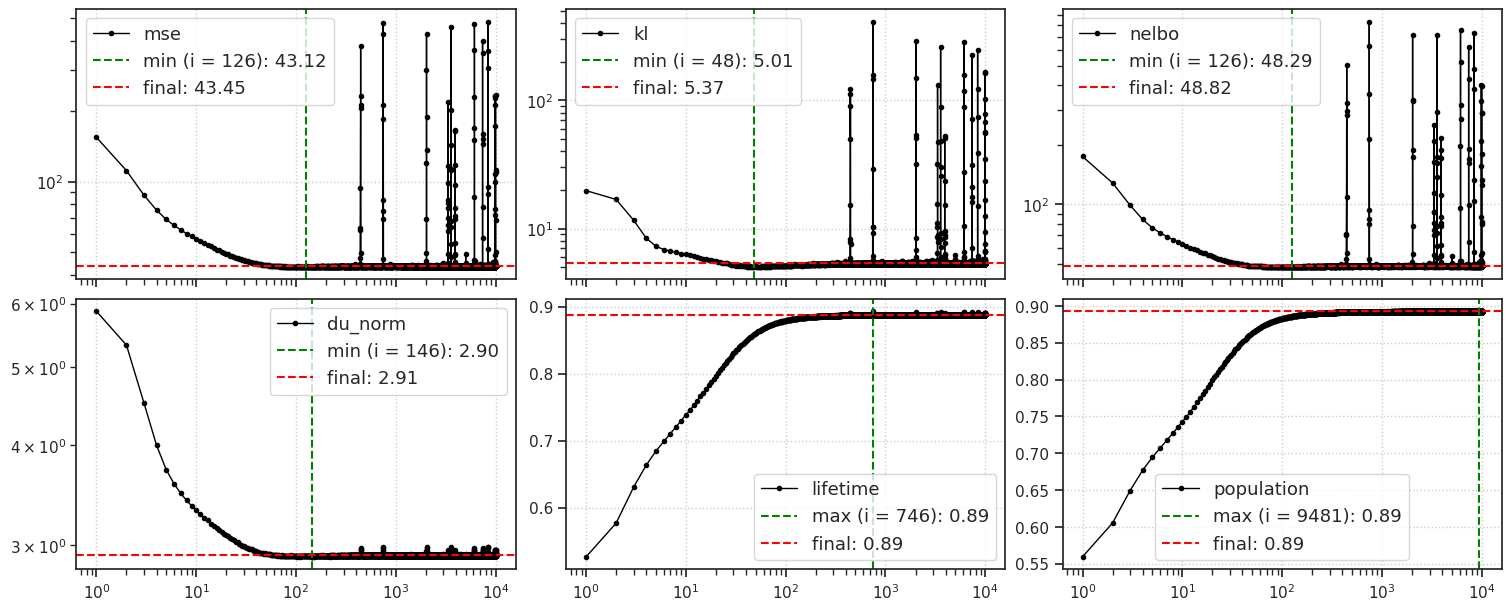

In [79]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=5,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

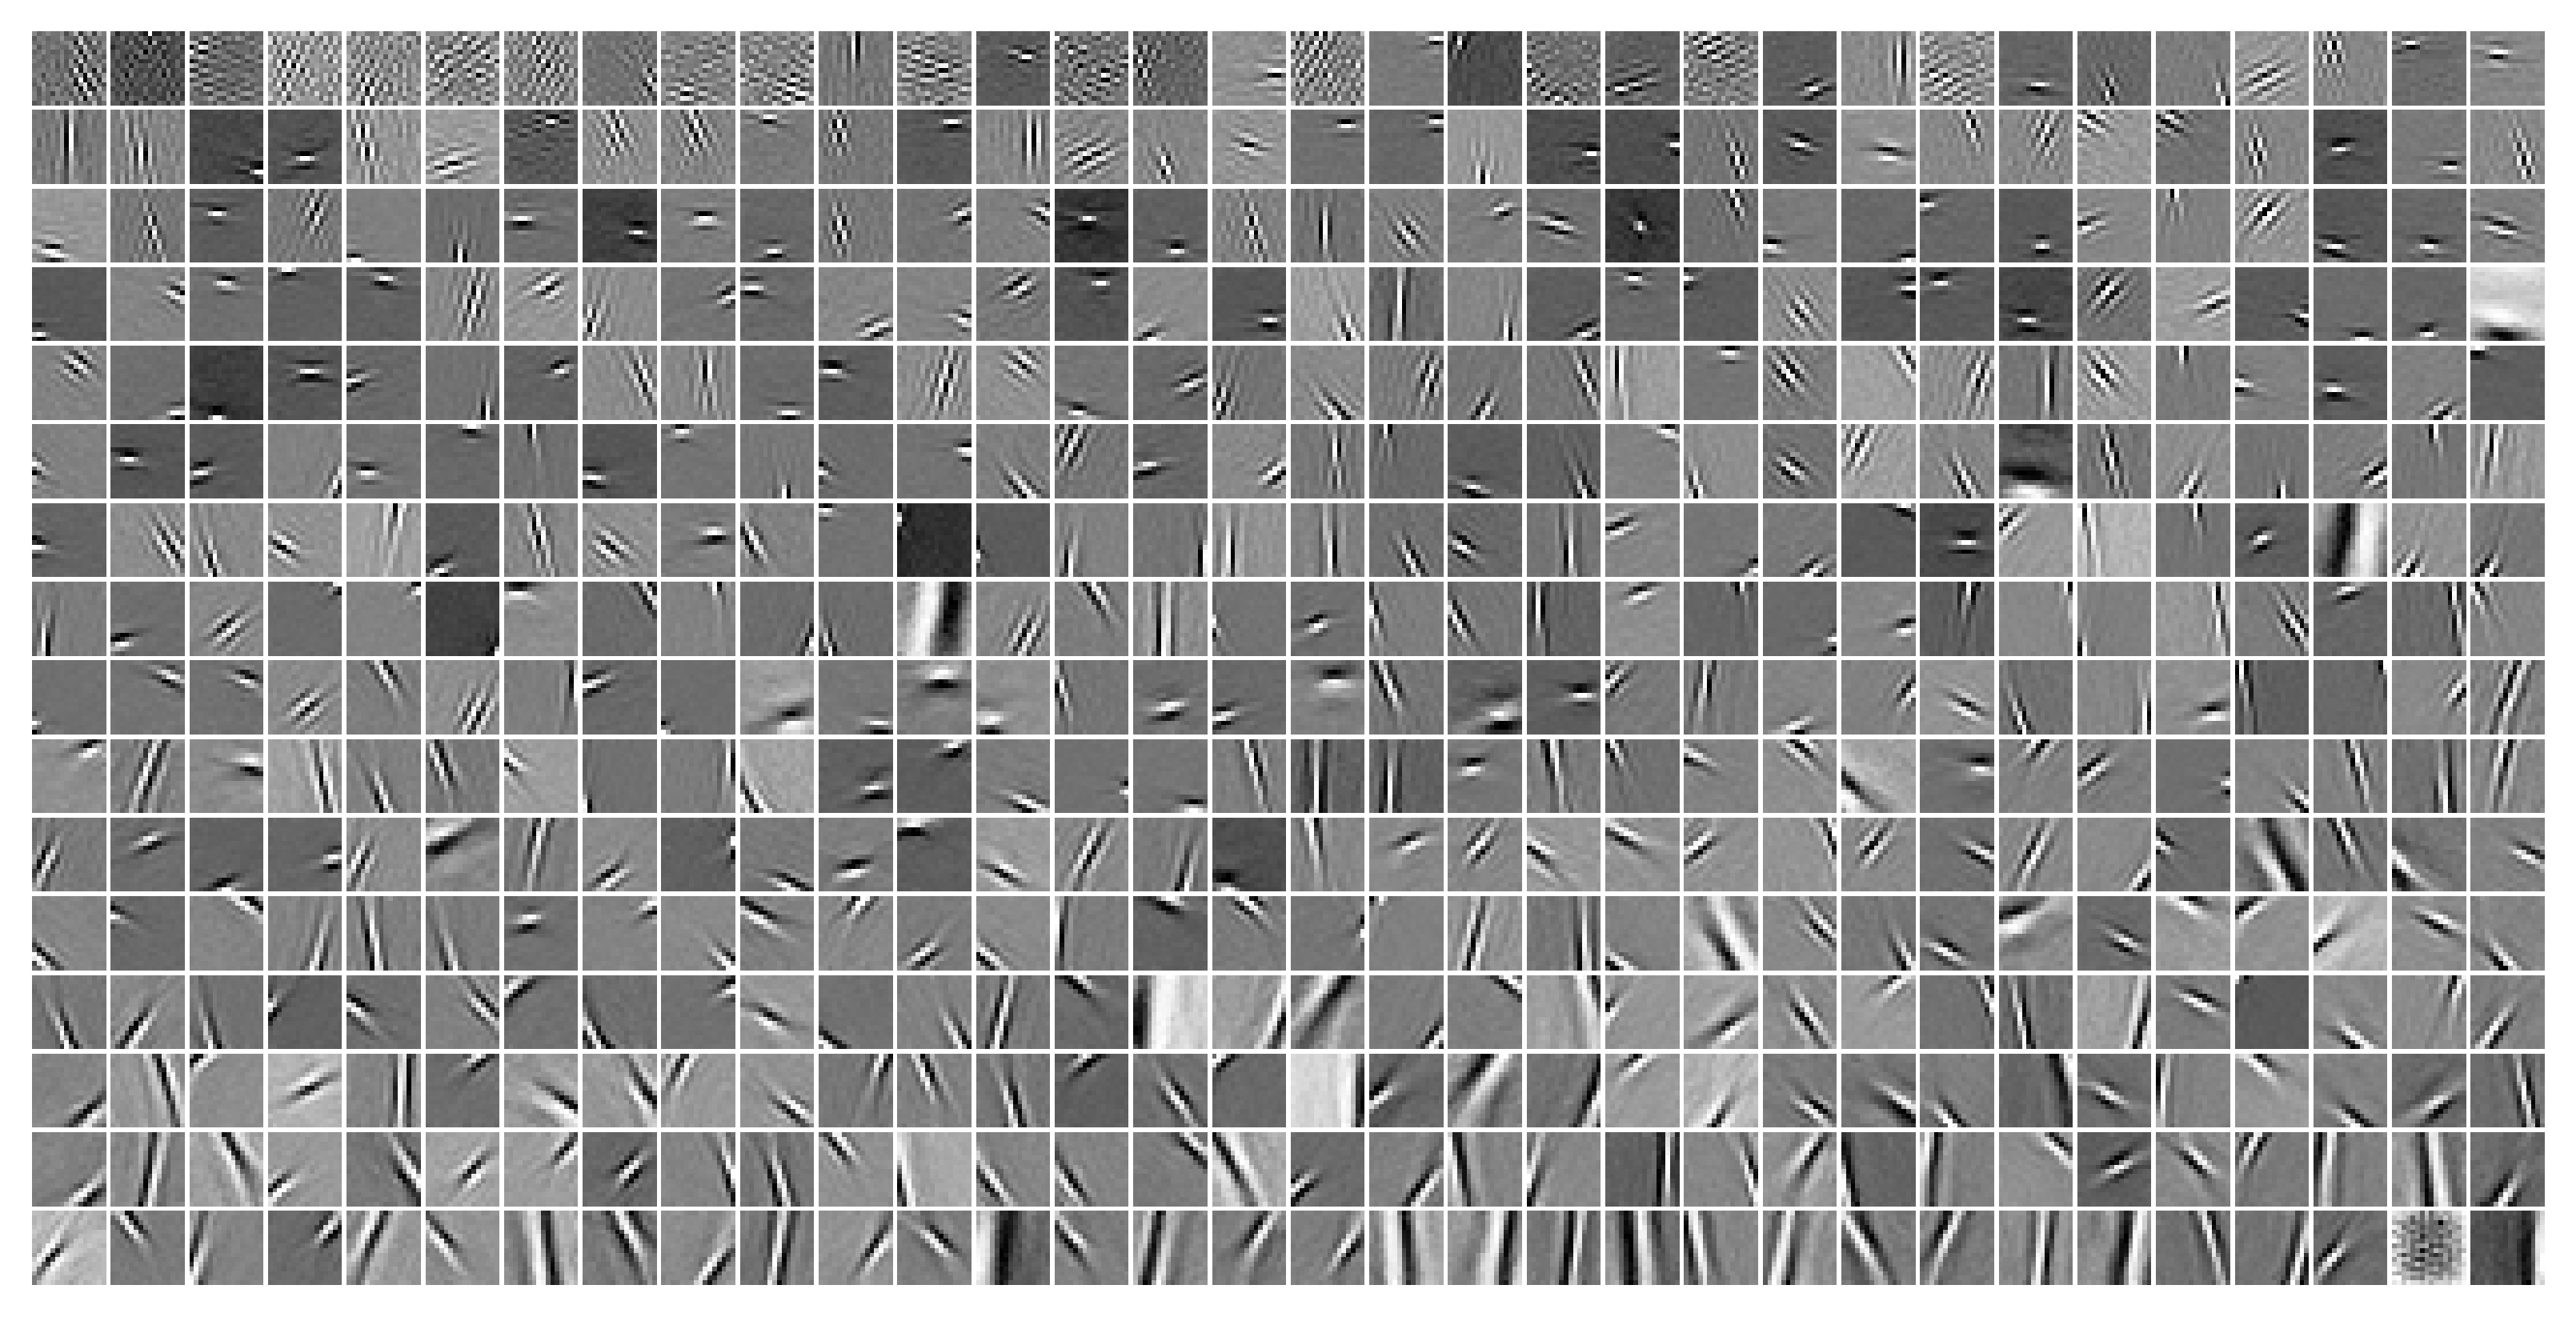

In [80]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

### High beta

$(T, \beta) = (4, 4.0)$

In [63]:
model_name = 'poisson_vH16_t-4_z-[512]_<jacob|lin>'
fit_name = 'u:(8.0)-du:(7.0)_b200-ep300-lr(0.002)_beta(4:0x0.1)_temp(0.05:lin-0.5)_gr(500)_(2024_09_12,18:21)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

300

In [64]:
tr.n_iters, tr.model.cfg.dataset, (tr.model.cfg.seq_len, float(tr.cfg.kl_beta))

(154500, 'vH16', (4, 4.0))

In [65]:
print(tr.model.layer.n_exp)

tensor([20, 42, 59, 61], device='cuda:0', dtype=torch.int32)

100%|█████████████████████████████████| 50/50 [23:31<00:00, 28.22s/it]


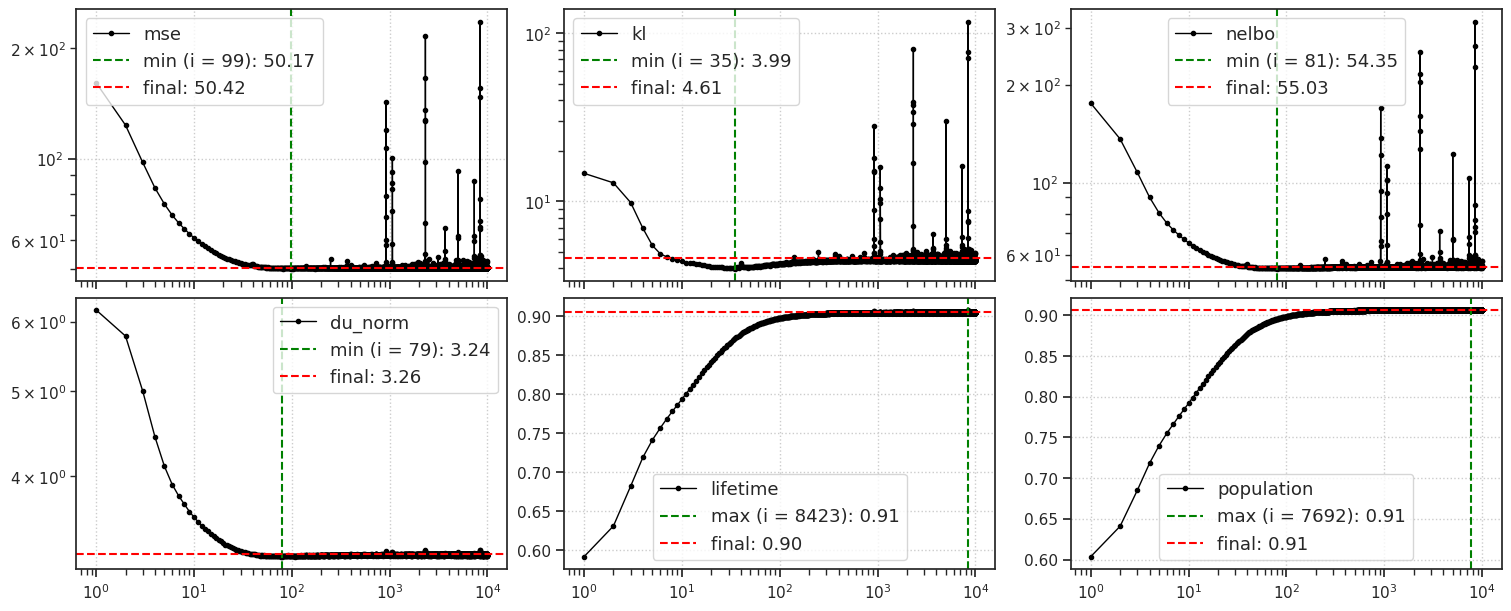

In [68]:
kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=50,
)
results = tr.analysis('vld', **kws)
_ = plot_convergence(results, color='k')

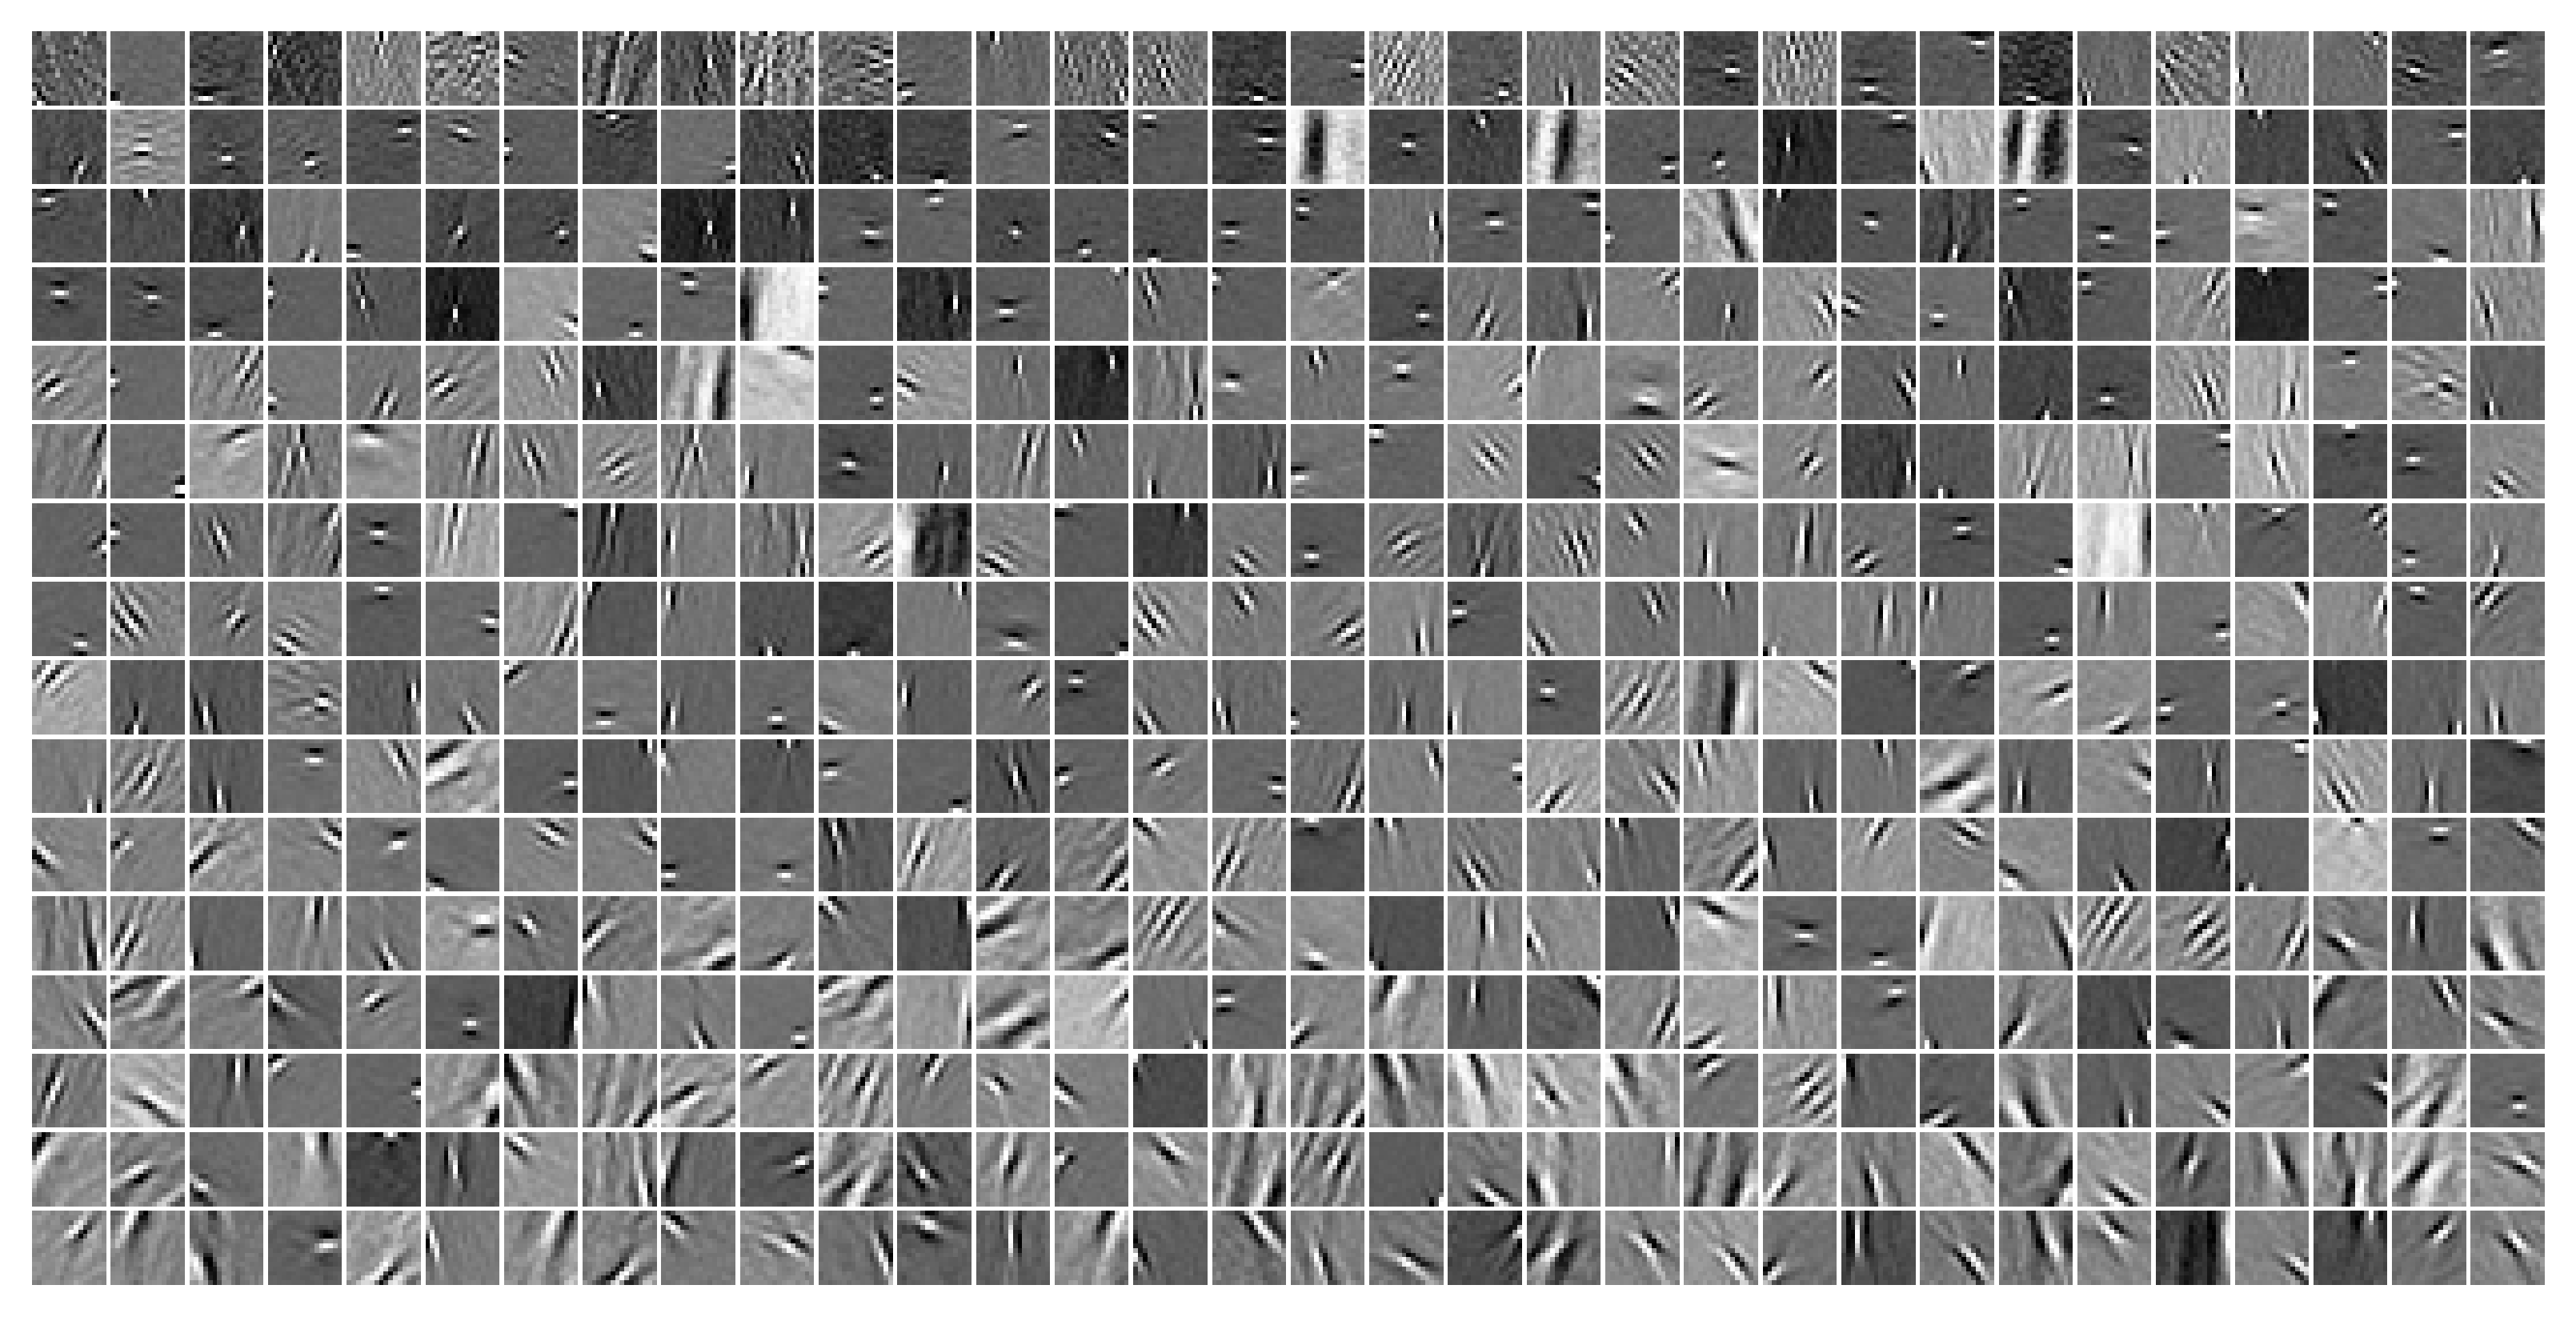

In [70]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
tr.model.show(order=np.argsort(log_rate), dpi=400);

## Older stuff

In [34]:
x = next(iter(tr.dl_vld))[0]

In [59]:
ff = []
for i in tqdm(range(100)):
    output = tr.model.xtract_ftr(
        x=x,
        seq=range(1000),
        return_extras=True,
    ).stack()
    ff.append(tonp(output['ff']))
ff = np.stack(ff)

100%|█████████████████████████████████████████| 100/100 [04:02<00:00,  2.42s/it]


In [60]:
ff.shape

(100, 200, 1000, 512)

In [63]:
du_expect = ff.mean(0)
du_expect_norm = np.linalg.norm(du_expect, axis=-1)
du_expect_norm_avg = du_expect_norm.mean(0)

du_expect_norm.shape

(200, 1000)

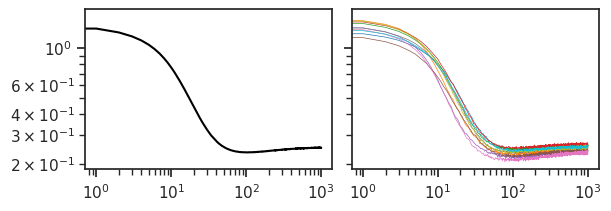

In [64]:
fig, axes = create_figure(1, 2, sharey='row')
axes[0].loglog(du_expect_norm_avg, color='k')
axes[1].loglog(du_expect_norm[:10].T, lw=0.5);

In [65]:
du_expect_norm_avg[-1]

0.2502581

<Axes: ylabel='Count'>

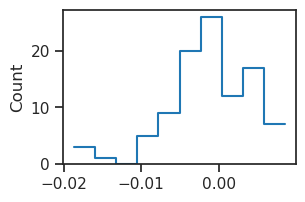

In [70]:
sample_i = 123
latent_i = 401
t = -1

histplot(ff[:, sample_i, t, latent_i])

In [71]:
ff[:, sample_i, t, latent_i].mean()

-0.0011150932

In [72]:
du_expect.shape

(200, 1000, 512)

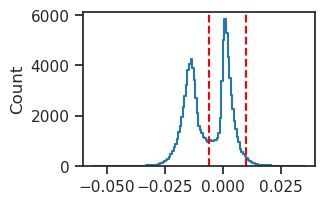

In [86]:
ax = histplot(du_expect[:, t, :].ravel())
ax.axvline(-0.006, color='r', ls='--')
ax.axvline(0.01, color='r', ls='--')

In [24]:
kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=1,
)
results = {}
for i in range(13):
    results[i] = tr.analysis('vld', **kws)

100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


In [25]:
results[4]['du_norm'].shape

(1000,)

In [27]:
{k: v.shape for k, v in results[4].items() if '_final' not in k}

{'kl': (1000,),
 'recon': (1000,),
 'nelbo': (1000,),
 'du_norm': (1000,),
 'lifetime': (1000,),
 'population': (1000,)}

In [29]:
results_trial = collections.defaultdict(list)
for d in results.values():
    for k, v in d.items():
        results_trial[k].append(v)
results_trial = {
    k: np.stack(v) for k, v
    in results_trial.items()
}

In [33]:
{k: v.shape for k, v in results_trial.items()}

{'kl': (13, 1000),
 'recon': (13, 1000),
 'nelbo': (13, 1000),
 'du_norm': (13, 1000),
 'lifetime': (13, 1000),
 'population': (13, 1000),
 'state_final': (13, 200, 512),
 'samples_final': (13, 200, 512)}

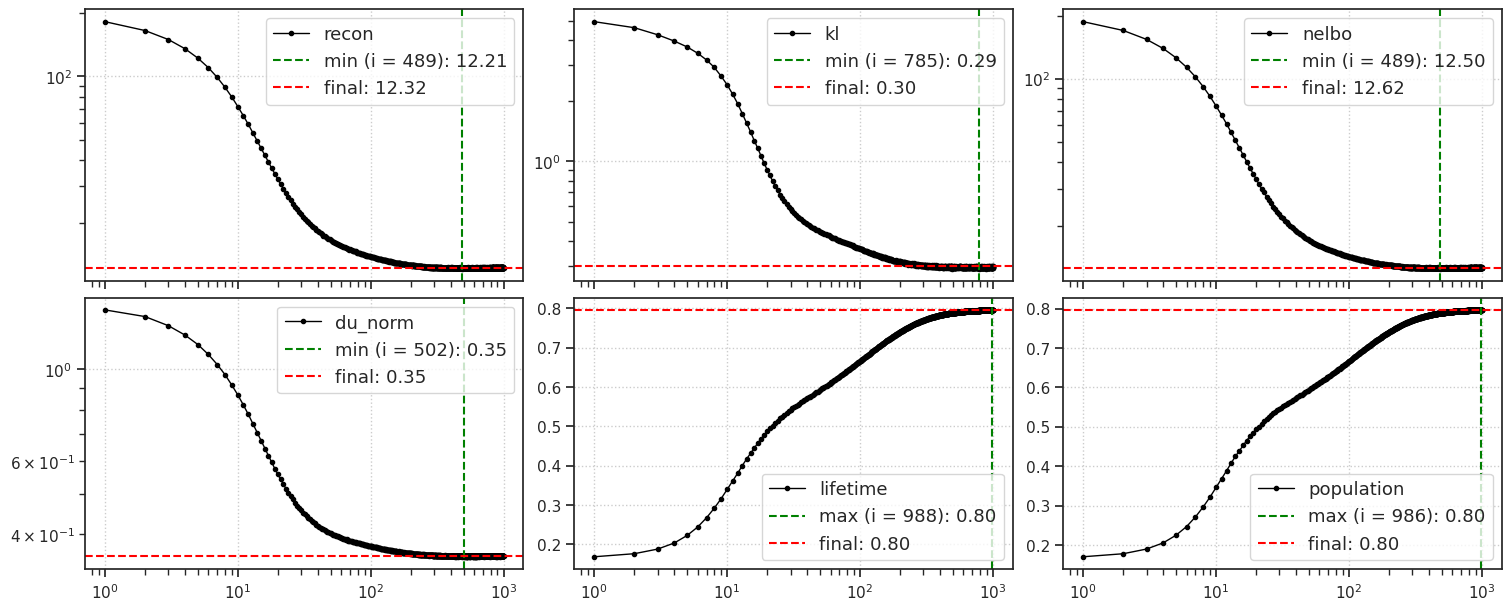

In [32]:
_ = plot_convergence({k: v.mean(0) for k, v in results_trial.items()}, color='k')

### Generate

In [15]:
n_samples = 128
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

In [16]:
n_iters = 200
output = tr.model.generate(pred, seq=range(n_iters))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['loss_kl', 'loss_recon', 'dist', 'ff', 'recon', 'state', 'samples']

In [17]:
shape = (n_samples, *tr.model.cfg.input_sz[1:])
pred = pred.reshape(shape)

shape_y = (n_samples, n_iters, *tr.model.cfg.input_sz[1:])
y = output['recon'].reshape(shape_y)

pred.shape, y.shape

(torch.Size([128, 16, 16]), torch.Size([128, 200, 16, 16]))

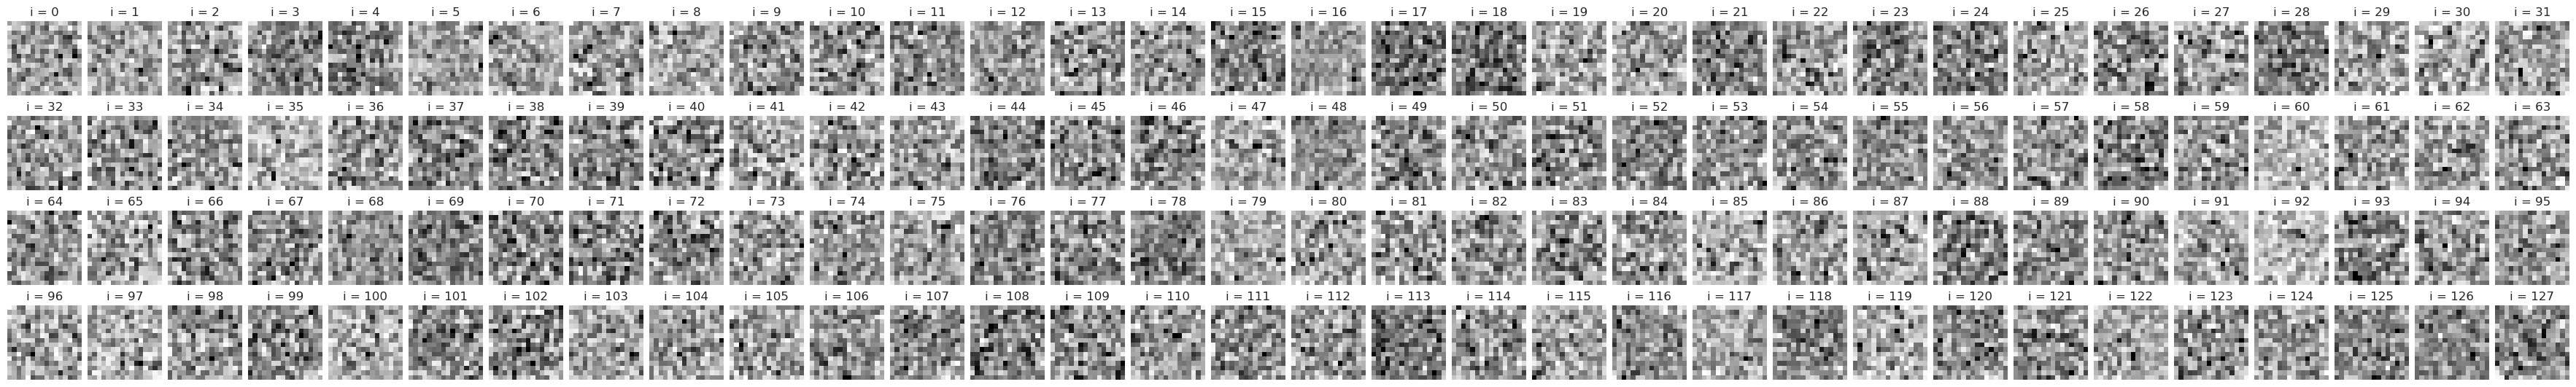

In [18]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')

for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    
    x2p = tonp(pred[sample_i])
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")

trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [19]:
sample_i = 30

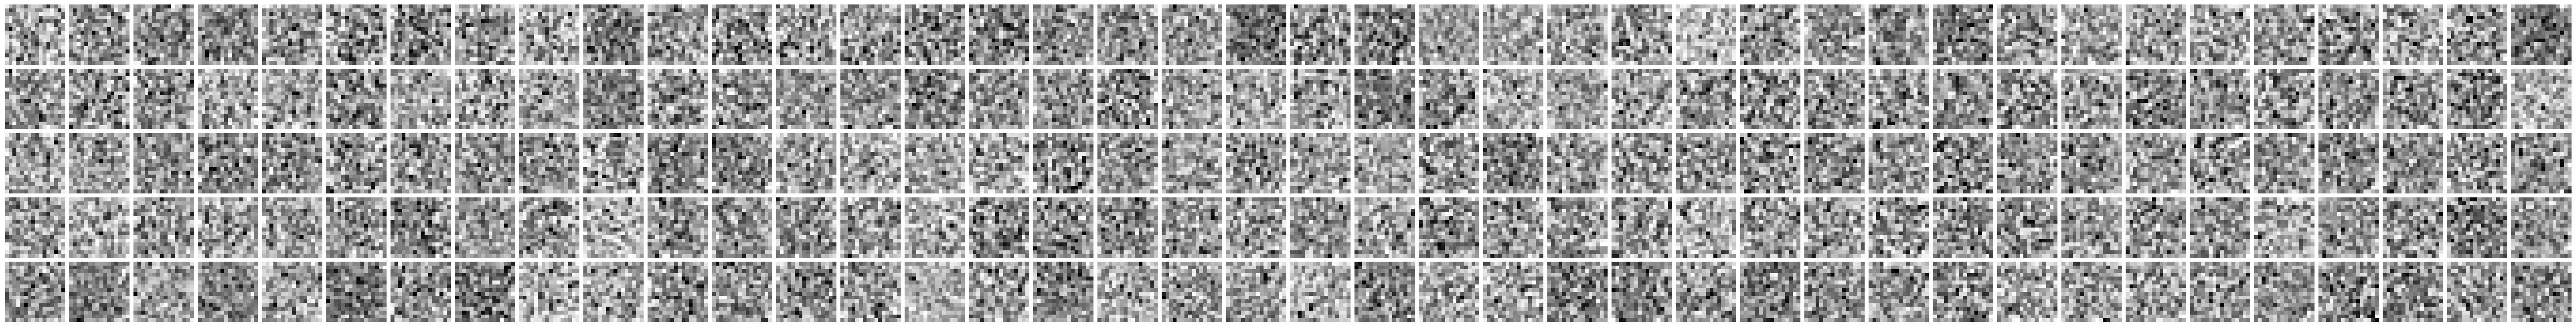

In [20]:
nrows, ncols = 5, 40
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')

for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    
    x2p = tonp(y[sample_i, idx])
    ax.imshow(x2p, cmap='Greys_r')

remove_ticks(axes)

In [21]:
order = np.argsort(desc_len)[::-1]

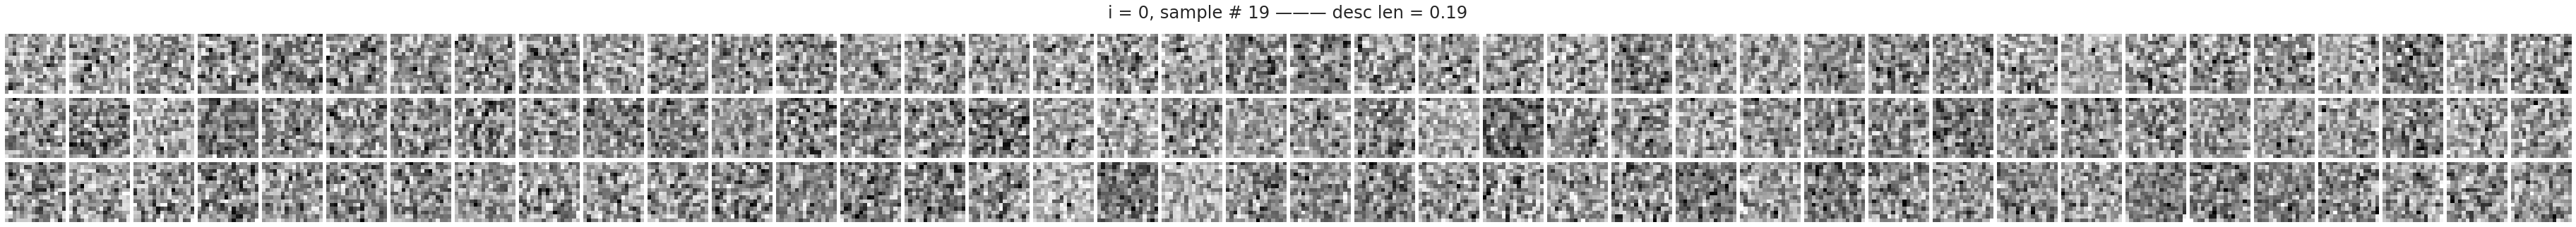

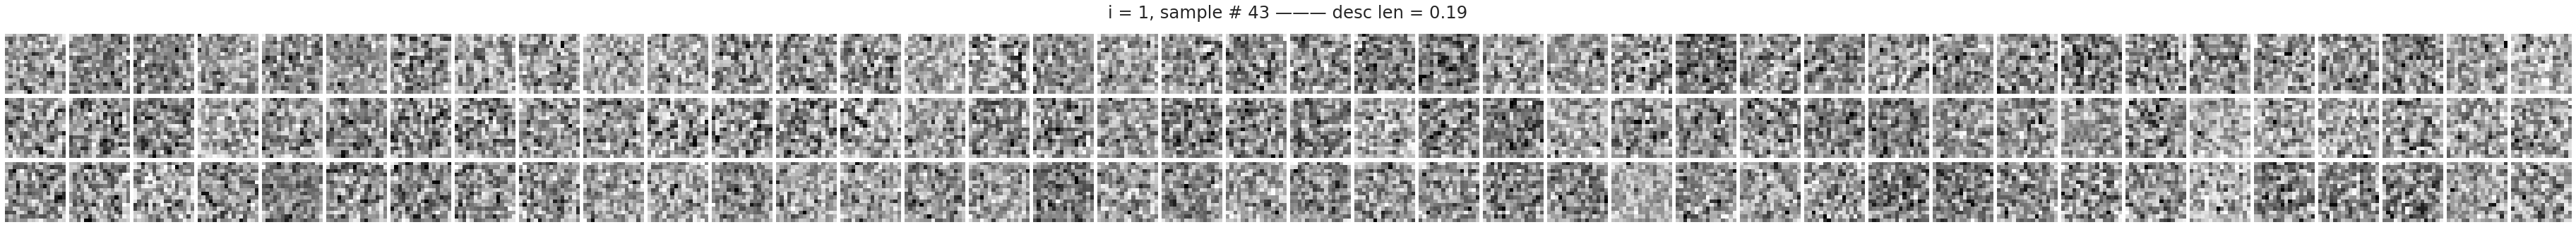

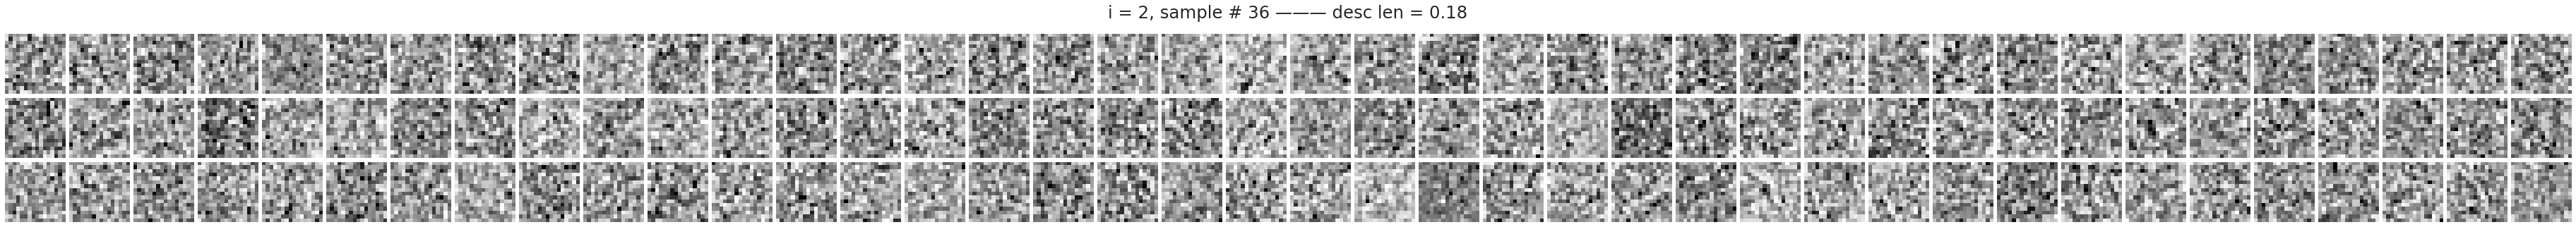

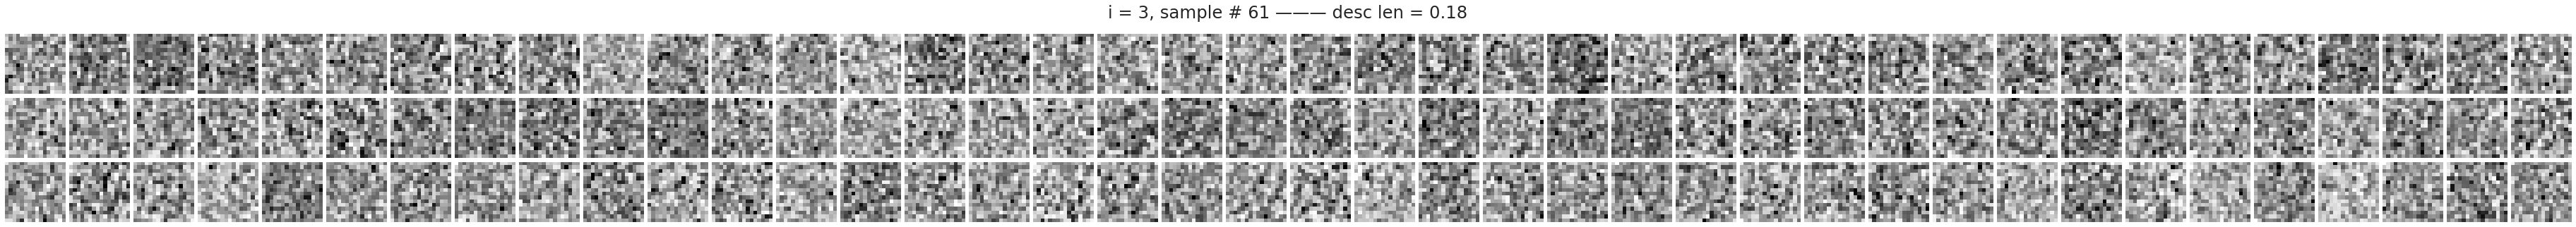

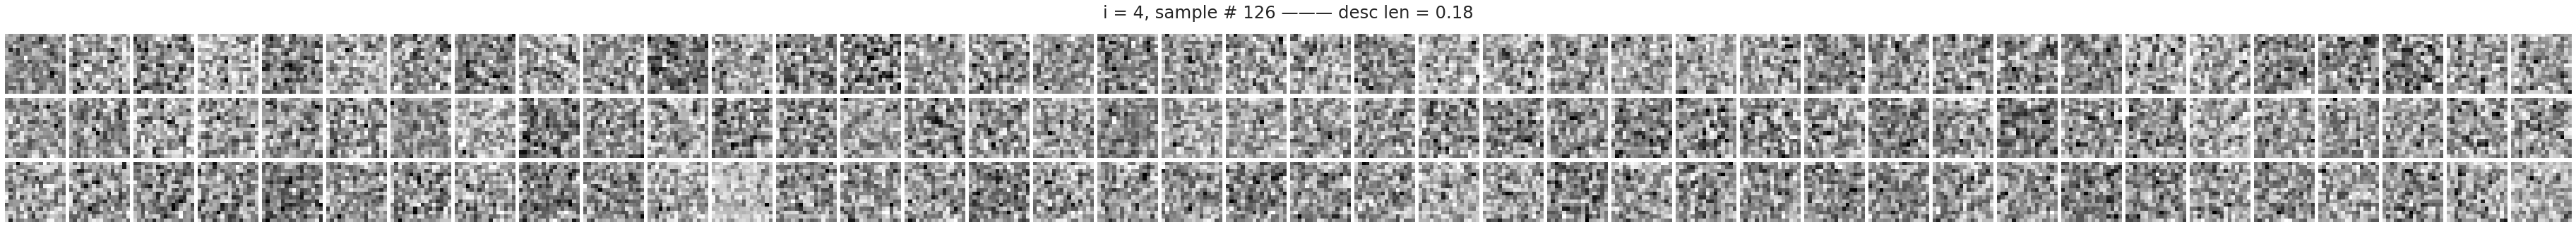

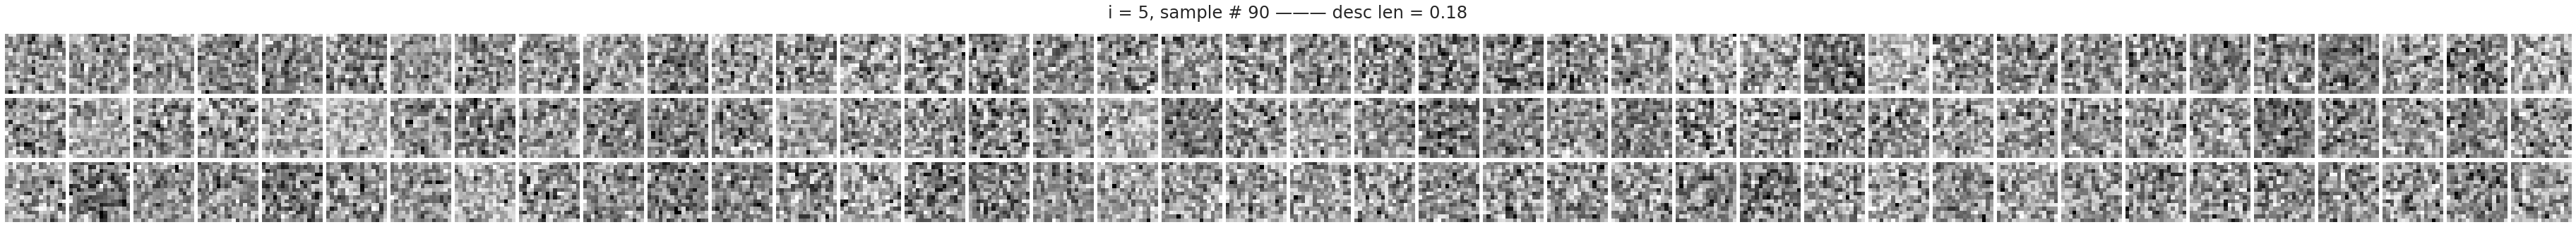

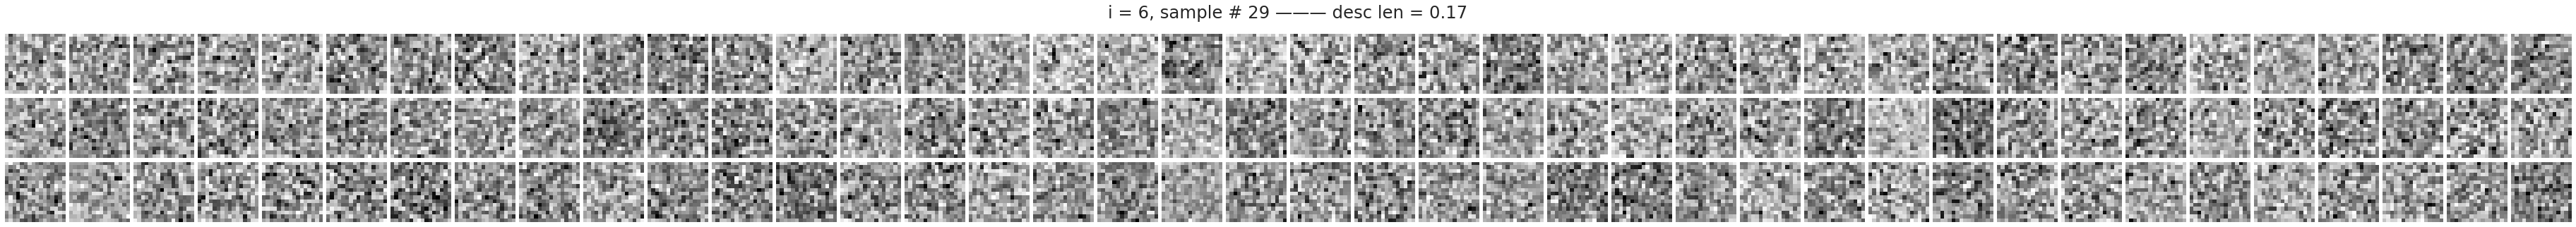

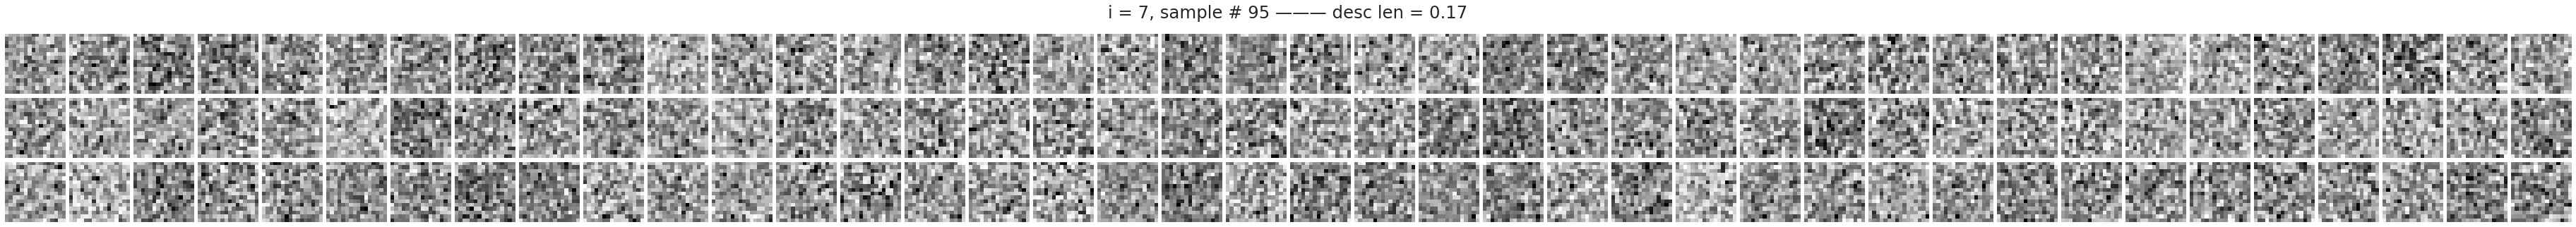

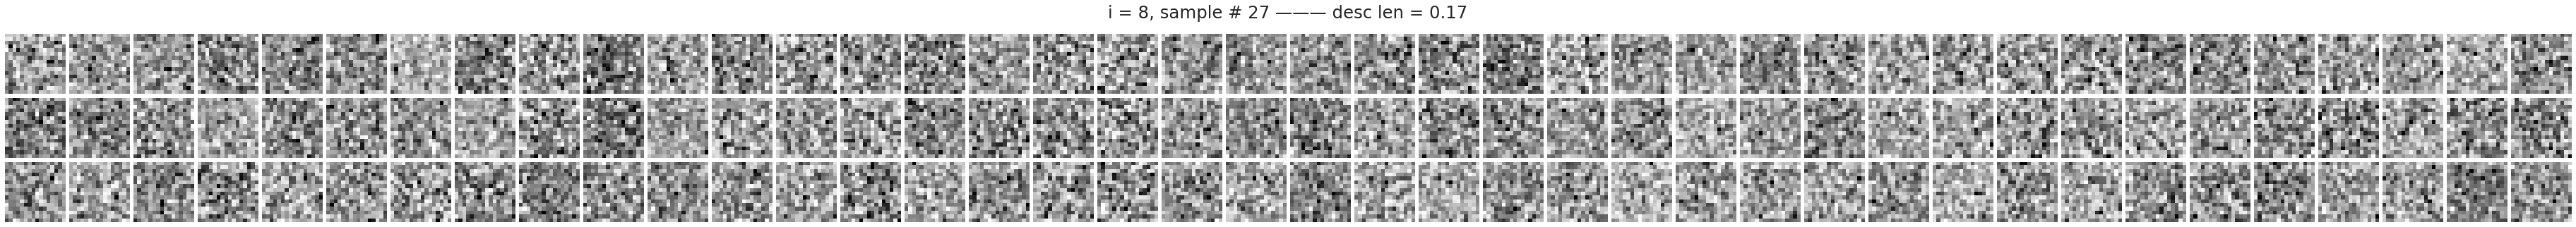

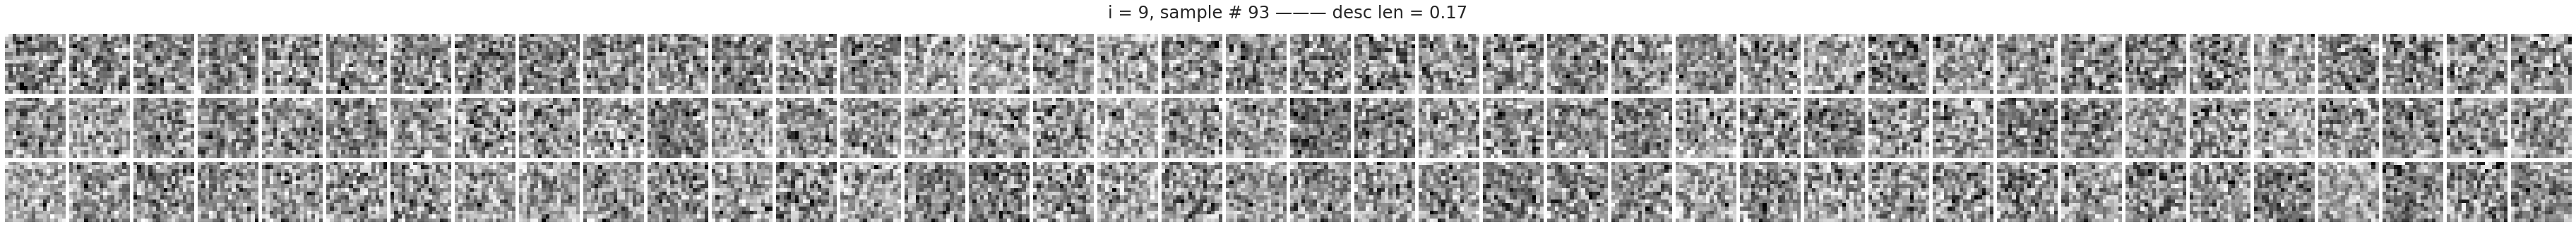

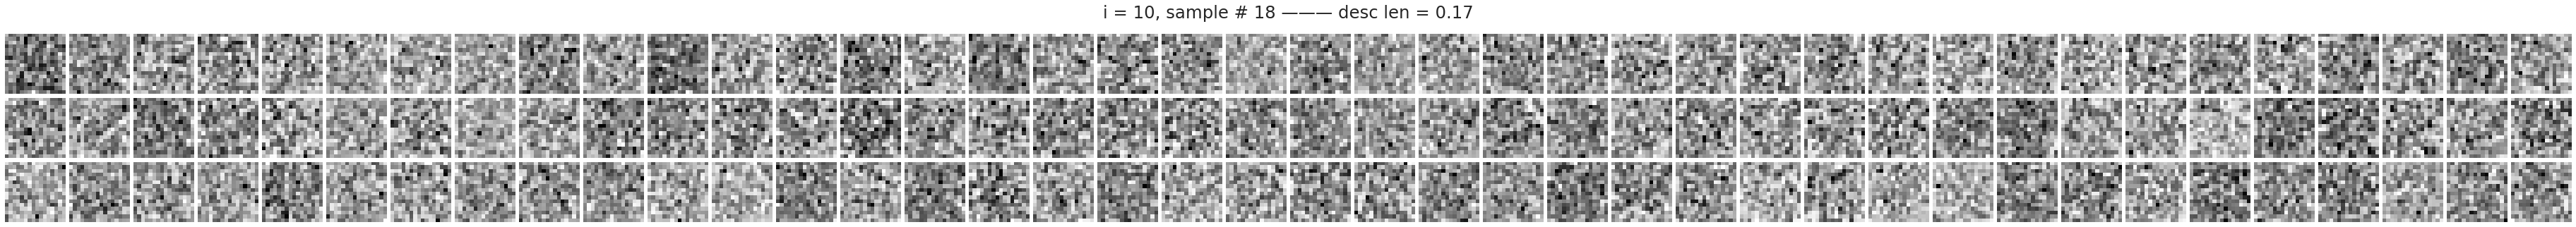

In [22]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 3, 40
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=70)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i])
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(y[sample_i, idx - 1])
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()

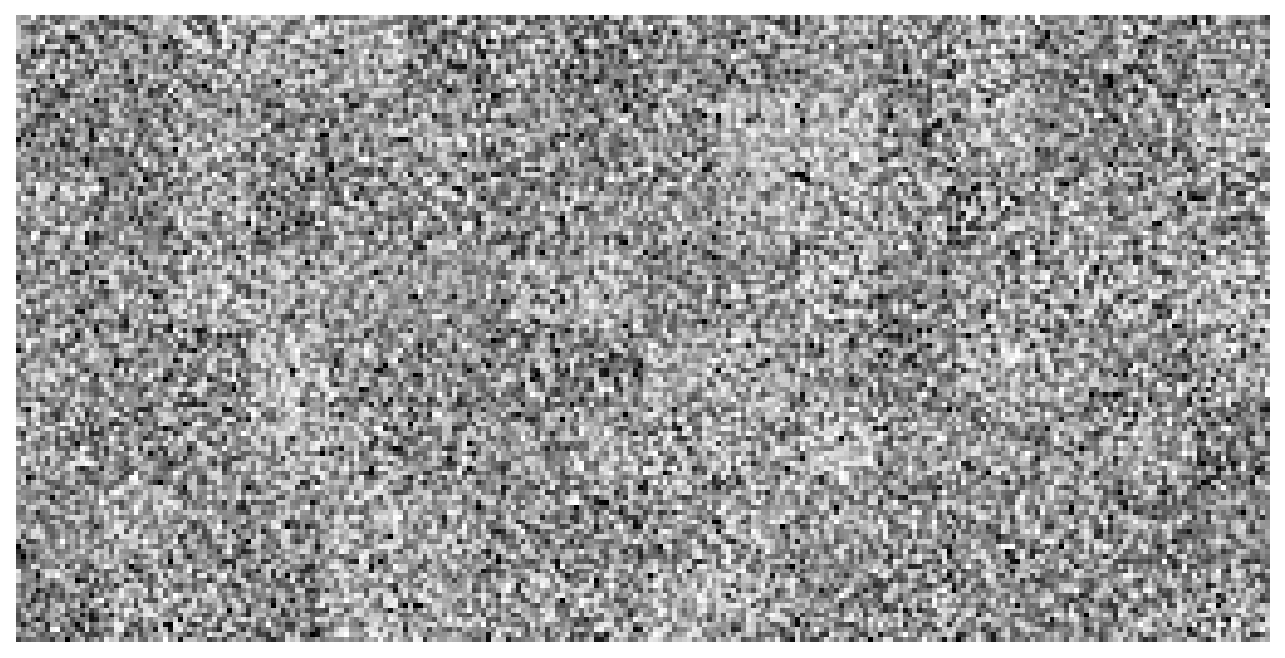

In [23]:
fig, ax = plot_weights(y[:, 80, ...], nrows=8, cmap='Greys', pad=0)
# fig.savefig(pjoin(fig_base_dir, 'generate-conv.pdf'), bbox_inches='tight')